# MOER Analyse
Dieses Notebook enthält verschiedene Analysen zur Beschaffenheit der MOER-Werte und zu Zusammenhänge der Daten, darunter:


*   Plot MOER Deutschland und Norwegen gesamt
*   Analyse zur Verteilung der Werte
*   ADF Test
*   Dekomposition
*   ACF und PACF
*   Korrelationsanalysen MOER und Eingabevariablen
*   MOER Verlauf Wochentage, Monate, Jahre
*   Potenzial zeitlicher und örtlicher Verschiebungen
*   Energiequellen-Zusammensetzung Stromnetze
*   Wetteranalyse monatlicher verlauf
*   72 höchste und niedrigste MOER-Werte Jan'24
*   Korrelationsanalyse MOER und Energiepreis
*   Analyse des Datensatzes ohne Ausreißer















In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import seaborn as sns
import pytz
import matplotlib.dates as mdates
from google.colab import drive
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

In [21]:
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/data_collection/'
figures_path = '/content/drive/My Drive/figures/'
moer_de_file_name = 'moer_DE_202210_202402.csv'
moer_no_file_name = 'moer_NO_202210_202402.csv'
weather_time_moer_file_name = 'weather_time_moer_2021_2024_DE_NO.csv'
weather_time_moer_filtered_file_name = 'weather_time_moer_filtered_2021_2024_DE_NO.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
weather_time_moer = pd.read_csv(base_path + weather_time_moer_file_name, index_col='date')
moer_de = weather_time_moer[weather_time_moer['country'] == "DE"][['moer']]
moer_no = weather_time_moer[weather_time_moer['country'] == "NO"][['moer']]

In [ ]:
moer_de

moer
date                           
2022-10-01 00:00:00  785.209331
2022-10-01 01:00:00  752.652765
2022-10-01 02:00:00  789.344578
2022-10-01 03:00:00  786.490729
2022-10-01 04:00:00  786.589007
...                         ...
2024-02-29 19:00:00  779.622590
2024-02-29 20:00:00  786.211014
2024-02-29 21:00:00  793.305948
2024-02-29 22:00:00  797.868328
2024-02-29 23:00:00  790.845212

[12408 rows x 1 columns]

In [ ]:
moer_de.describe()

moer
count  12408.000000
mean     746.785318
std       82.127004
min       19.927809
25%      745.036200
50%      762.985213
75%      783.267391
max      856.120881

In [ ]:
moer_no.describe()

moer
count  27720.000000
mean     245.760136
std       45.095488
min       95.821310
25%      221.292417
50%      236.835503
75%      257.629861
max      524.794604

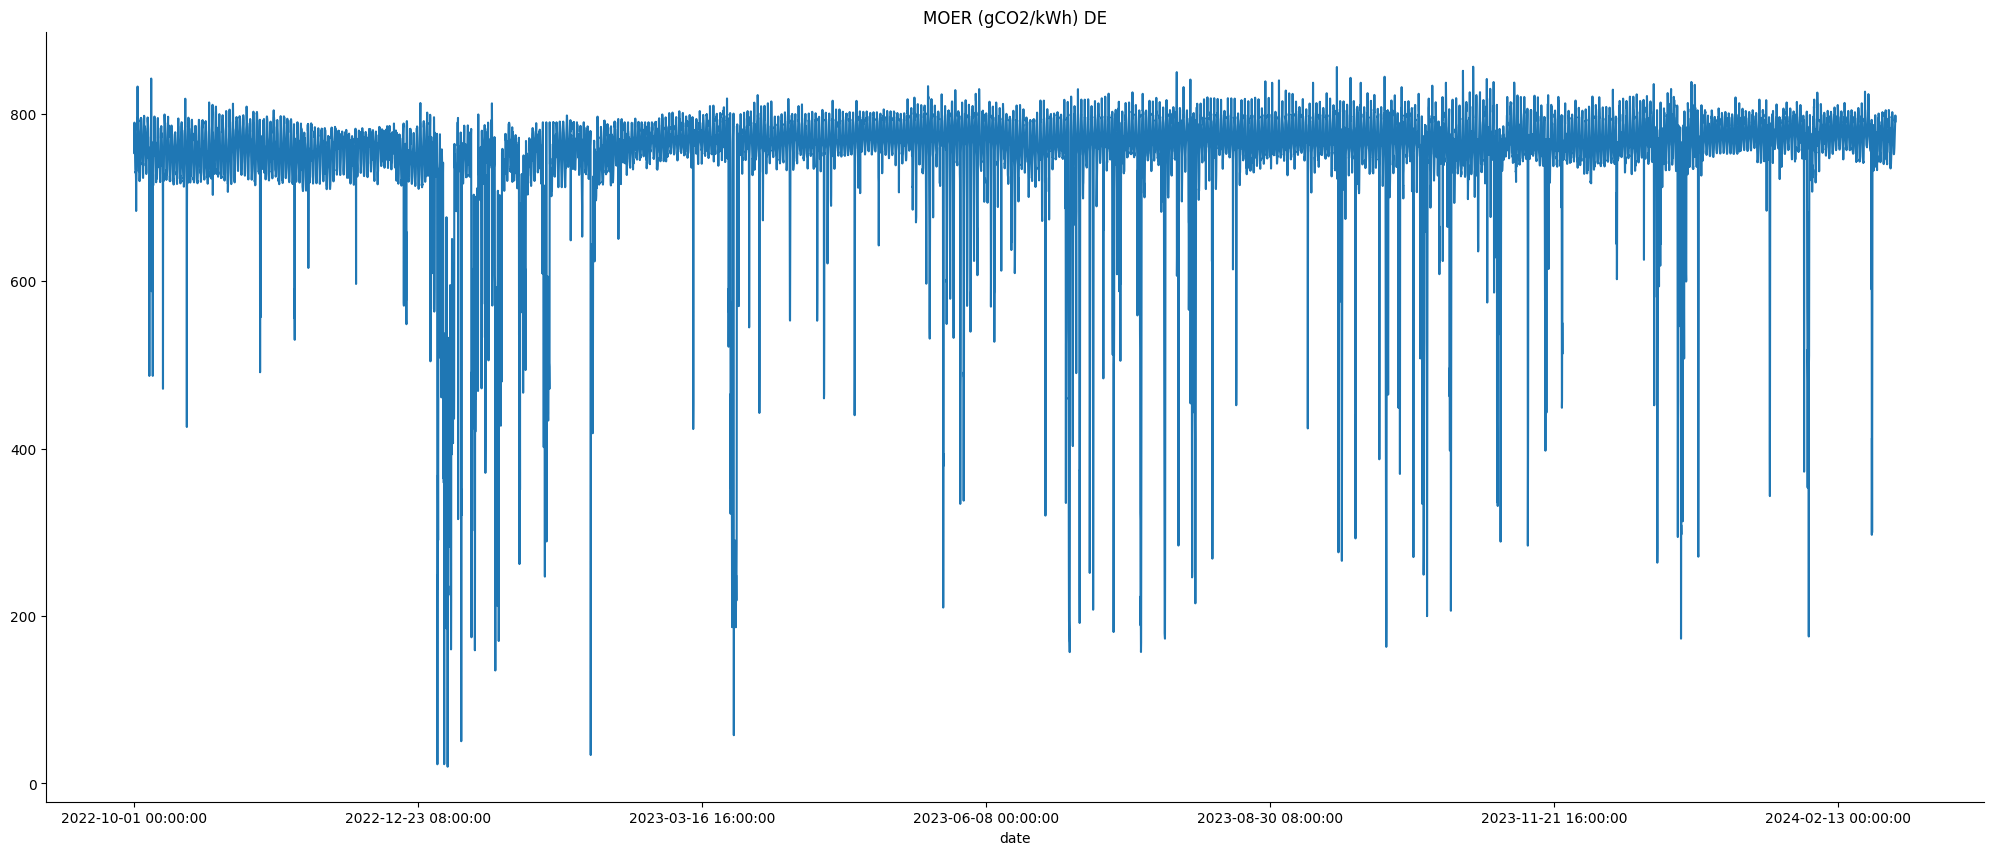

In [ ]:
moer_de['moer'].plot(kind='line', figsize=(25, 10), title='MOER (gCO2/kWh) DE')
plt.gca().spines[['top', 'right']].set_visible(False)

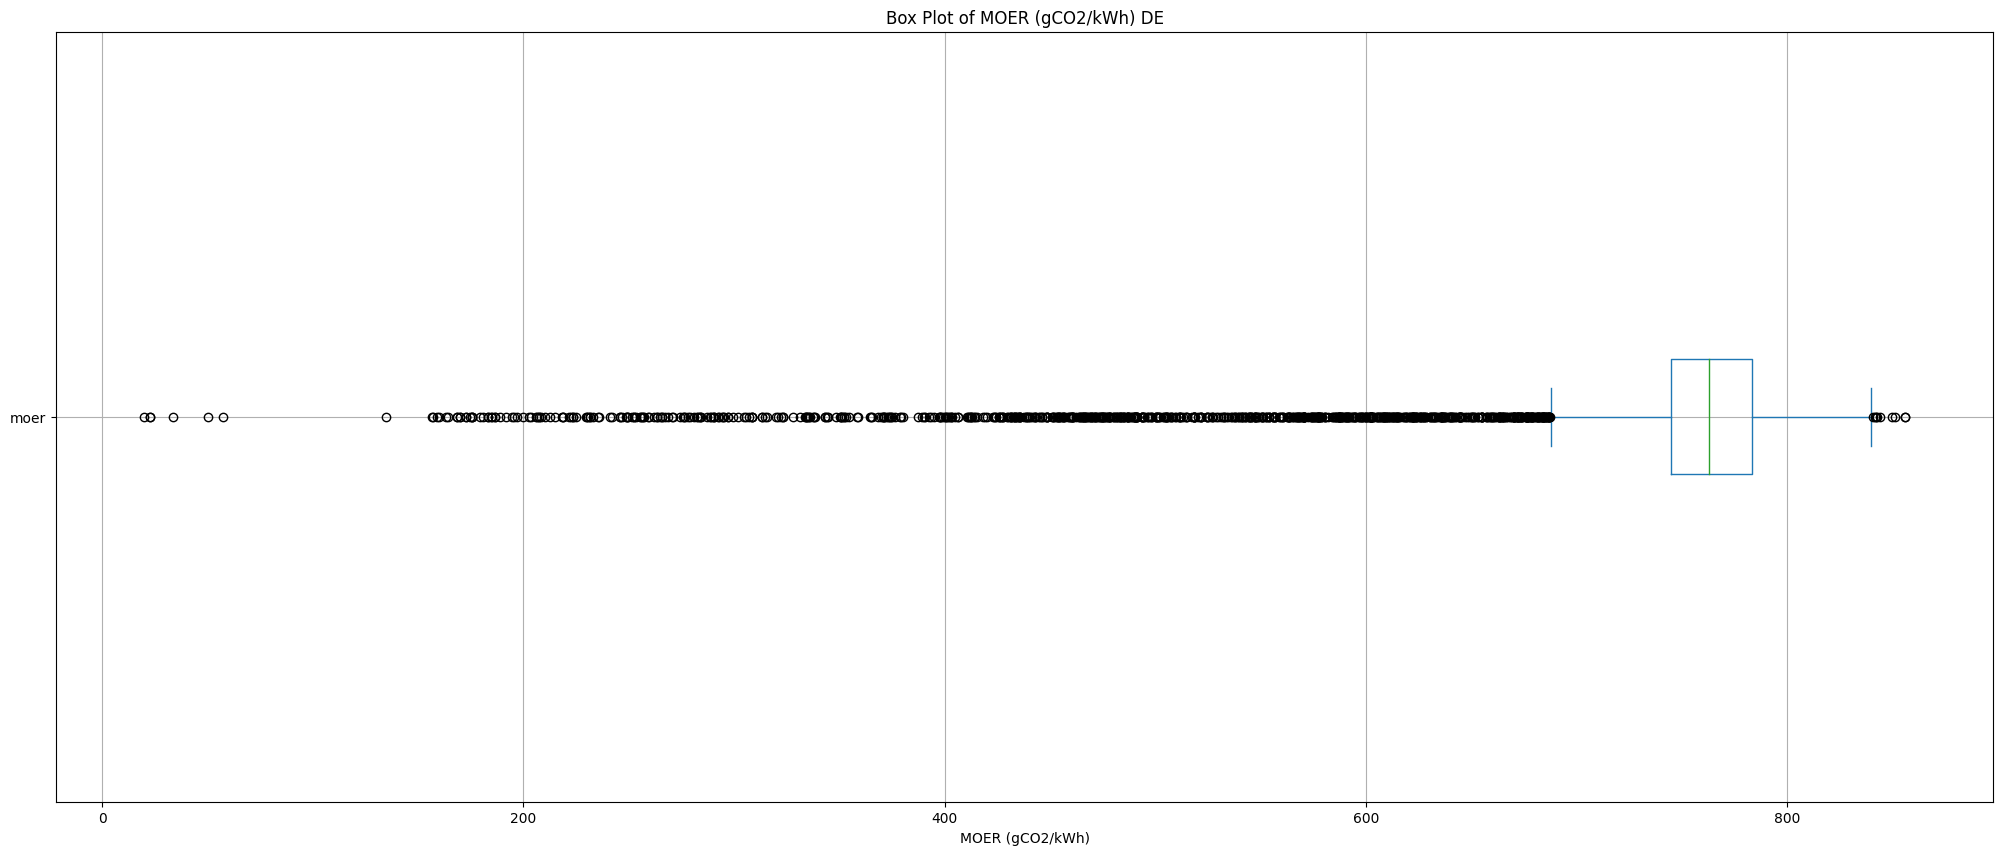

In [ ]:
plt.figure(figsize=(25, 10))
moer_de['moer'].plot(kind='box', vert=False)
plt.title('Box Plot of MOER DE')
plt.xlabel('MOER (gCO2/kWh)')
plt.grid(True)
plt.show()

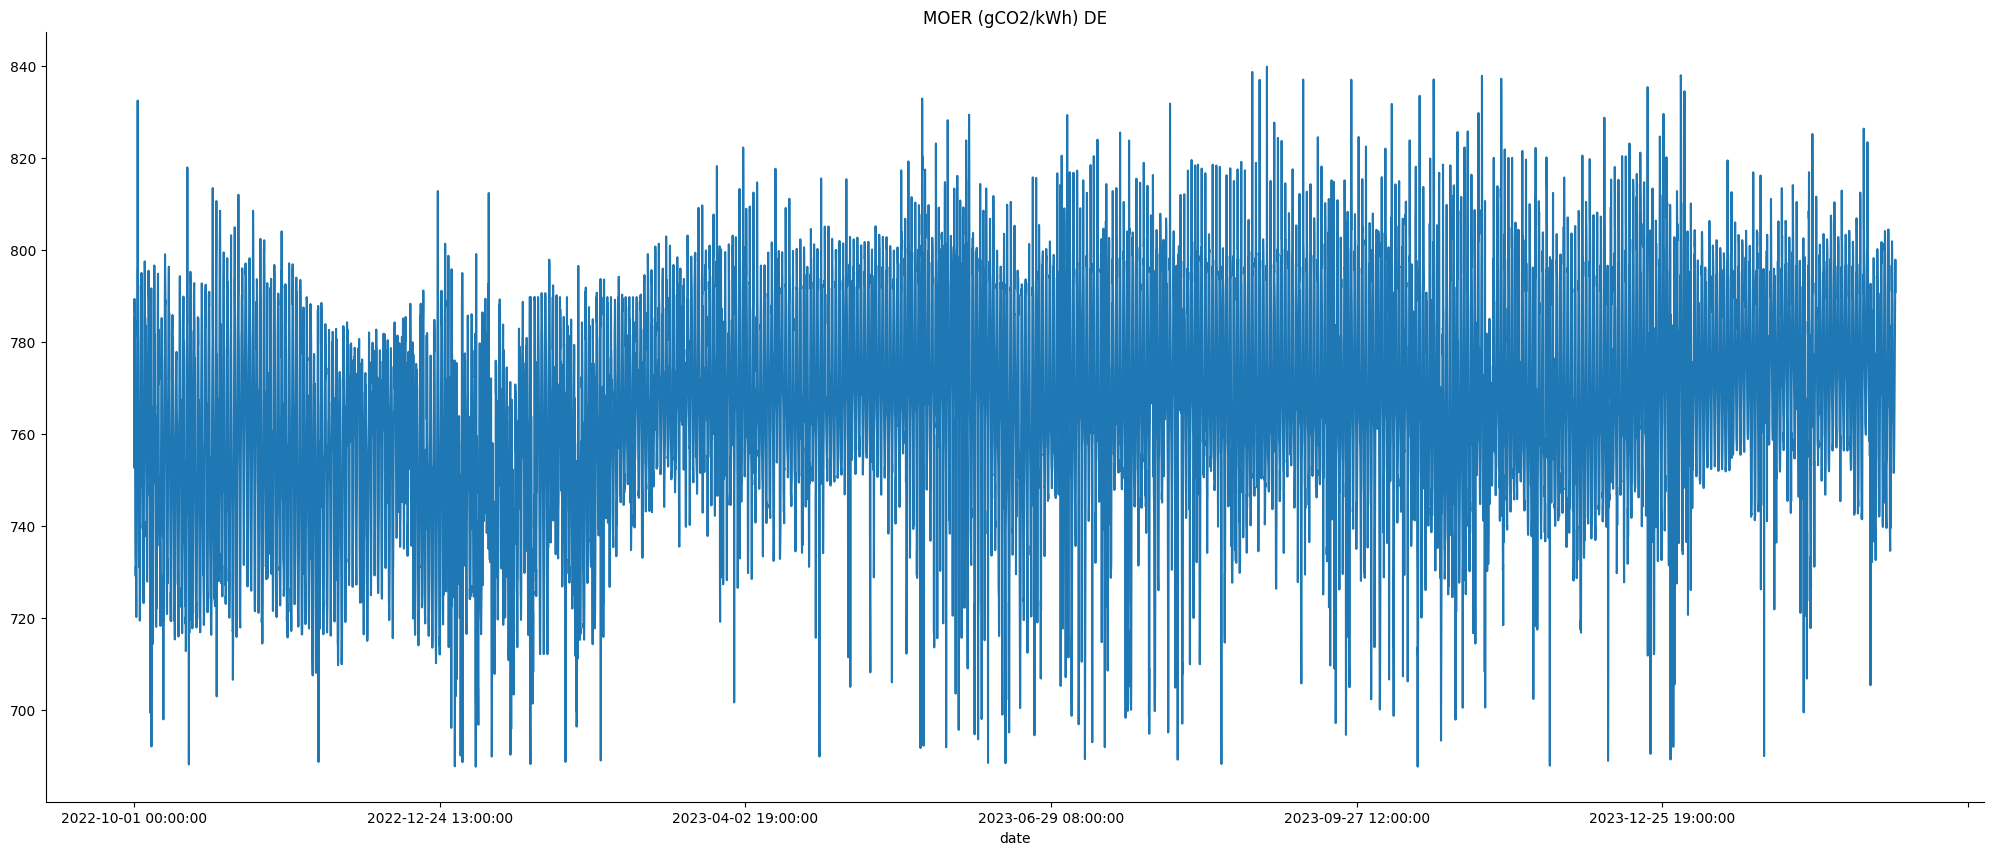

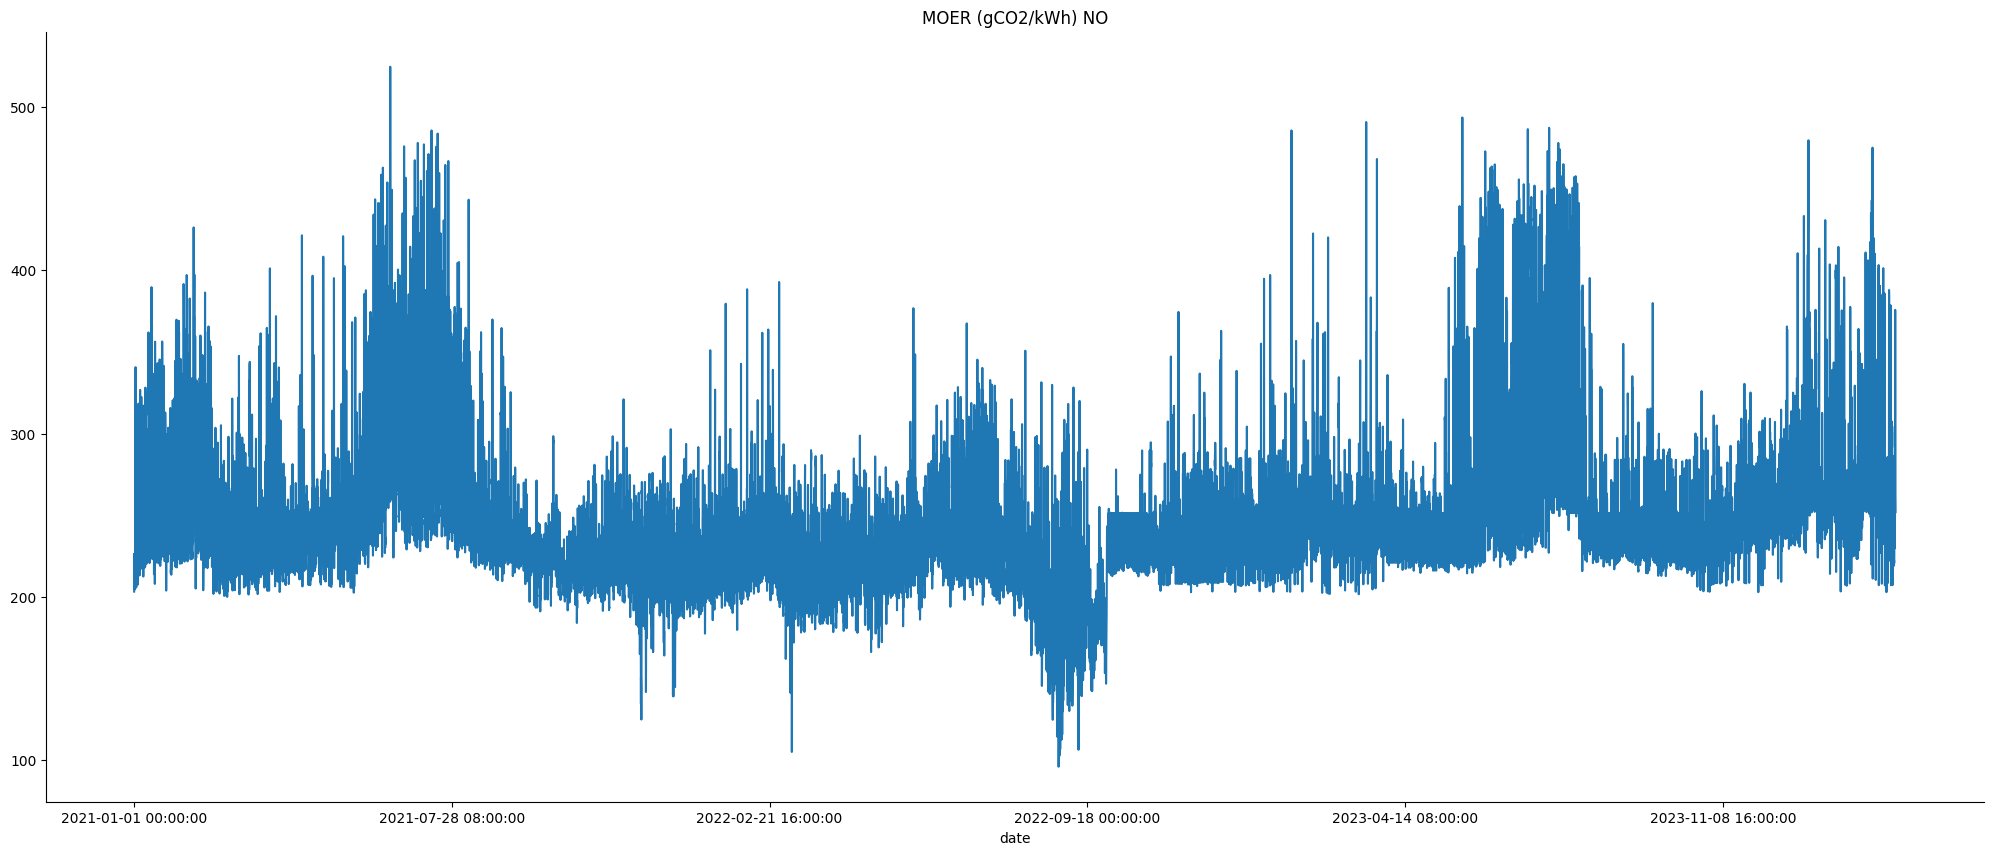

In [ ]:
moer_no['moer'].plot(kind='line', figsize=(25, 10), title='MOER (gCO2/kWh) NO')
plt.gca().spines[['top', 'right']].set_visible(False)

Average Operating Emissions Rate

In [ ]:
aoer_de_df = pd.DataFrame()
aoer_files_de = glob.glob(os.path.join(base_path, 'WattTime/aoer_DE_*.csv'))

for file in aoer_files_de:
    df = pd.read_csv(file, index_col='date')
    df['country'] = 'DE'
    aoer_de_df = pd.concat([aoer_de_df, df])
aoer_de_df.sort_values('date')

aoer country
date                                   
2021-01-01 00:00:00  521.896605      DE
2021-01-01 01:00:00  543.463725      DE
2021-01-01 02:00:00  591.664634      DE
2021-01-01 03:00:00  596.011587      DE
2021-01-01 04:00:00  596.512625      DE
...                         ...     ...
2024-02-29 20:00:00  373.188554      DE
2024-02-29 21:00:00  381.889946      DE
2024-02-29 22:00:00  397.757456      DE
2024-02-29 23:00:00  405.993825      DE
2024-03-01 00:00:00  437.626741      DE

[38000 rows x 2 columns]

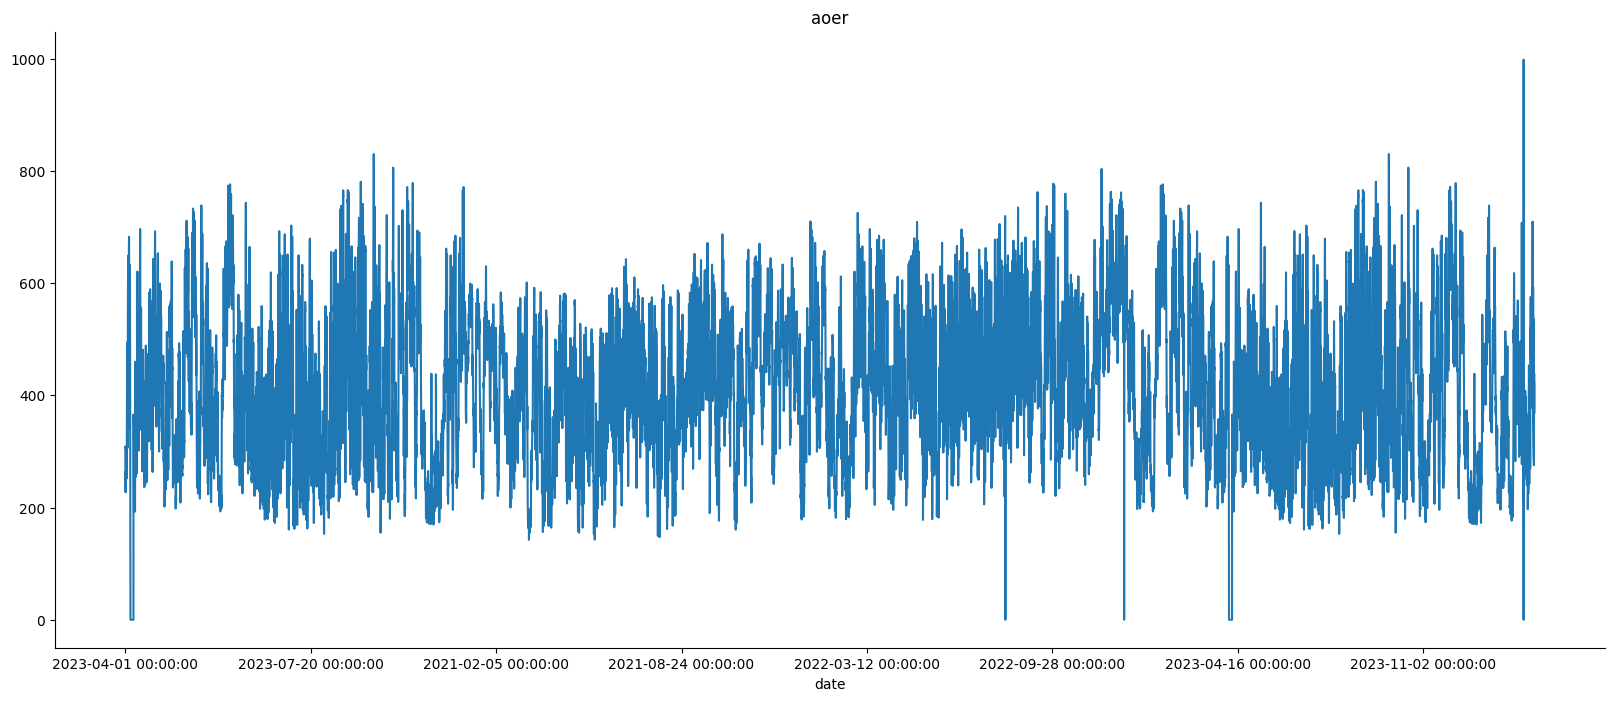

In [ ]:
aoer_de_df['aoer'].plot(kind='line', figsize=(20, 8), title='aoer')
plt.gca().spines[['top', 'right']].set_visible(False)

**Distribution**

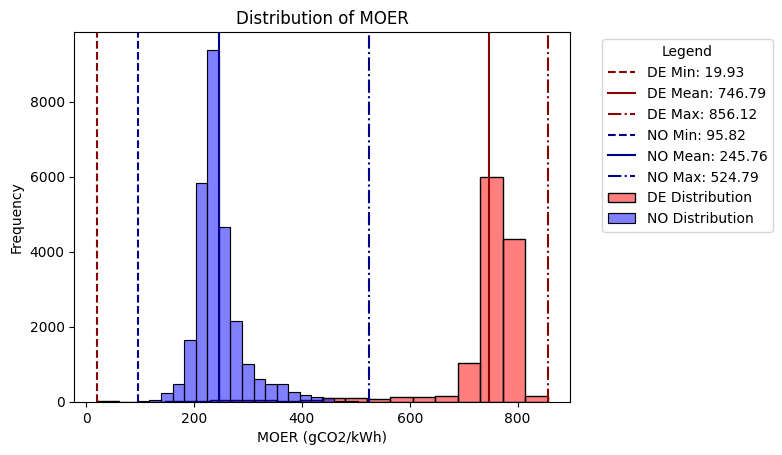

In [ ]:
sns.histplot(data=moer_de, x='moer', bins=20, color='red', alpha=0.5, label='DE Distribution')
sns.histplot(data=moer_no, x='moer', bins=20, color='blue', alpha=0.5, label='NO Distribution')

min_de, max_de, mean_de = moer_de['moer'].min(), moer_de['moer'].max(), moer_de['moer'].mean()
min_no, max_no, mean_no = moer_no['moer'].min(), moer_no['moer'].max(), moer_no['moer'].mean()

plt.axvline(min_de, color='darkred', linestyle='--', label=f'DE Min: {min_de:.2f}')
plt.axvline(mean_de, color='darkred', linestyle='-', label=f'DE Mean: {mean_de:.2f}')
plt.axvline(max_de, color='darkred', linestyle='-.', label=f'DE Max: {max_de:.2f}')

plt.axvline(min_no, color='darkblue', linestyle='--', label=f'NO Min: {min_no:.2f}')
plt.axvline(mean_no, color='darkblue', linestyle='-', label=f'NO Mean: {mean_no:.2f}')
plt.axvline(max_no, color='darkblue', linestyle='-.', label=f'NO Max: {max_no:.2f}')

plt.title('Distribution of MOER')
plt.xlabel('MOER (gCO2/kWh)')
plt.ylabel('Frequency')

plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.savefig('moer_distribution.png', bbox_inches='tight')
plt.show()

**Augmented Dickey Fuller Test**

In [ ]:
# ADF test
# H0: data is non stationary
# H1: data is stationary

moer_values = moer_de['moer'].values
result = adfuller(moer_values)

adf_statistic = result[0]
p_value = result[1]
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print('null hypothesis rejected --> data is stationary')
else:
    print('Failed to reject null hypothesis --> data is not stationary')

ADF Statistic: -12.99035452395651
p-value: 2.82098093226533e-24
null hypothesis rejected --> data is stationary


In [ ]:
# ADF test
# H0: data is non stationary
# H1: data is stationary

moer_values = moer_no['moer'].values
result = adfuller(moer_values)

adf_statistic = result[0]
p_value = result[1]
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print('null hypothesis rejected --> data is stationary')
else:
    print('Failed to reject null hypothesis --> data is not stationary')

ADF Statistic: -4.449123008253226
p-value: 0.0002427305656132865
null hypothesis rejected --> data is stationary


**Decomposition DE**

<ipython-input-36-8d9ded15d8cd>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 1)


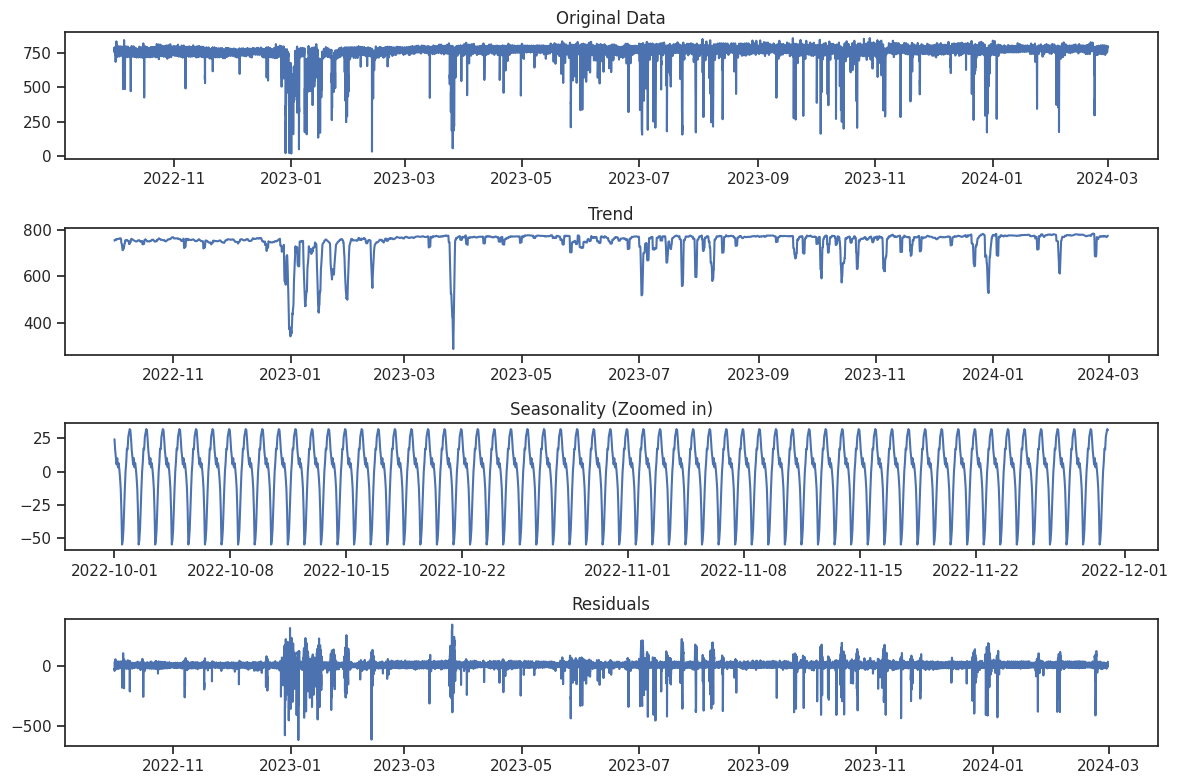

In [ ]:
moer_de.index = pd.DatetimeIndex(moer_de.index)

decomposition = seasonal_decompose(moer_de['moer'], model='additive')
seasonal_subset = decomposition.seasonal.iloc[:1440]

plt.figure(figsize=(12, 8))
plt.xlim('2022-10-01', '2023-12-31')

plt.subplot(4, 1, 1)
plt.plot(moer_de['moer'])
plt.title('Original Data')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(seasonal_subset)
plt.title('Seasonality (Zoomed in)')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
# plt.savefig(figures_path + 'moer_decomposition_DE.png', bbox_inches='tight')
plt.show()

**Decomposition NO**

<ipython-input-9-7d63a2771c0d>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 1)


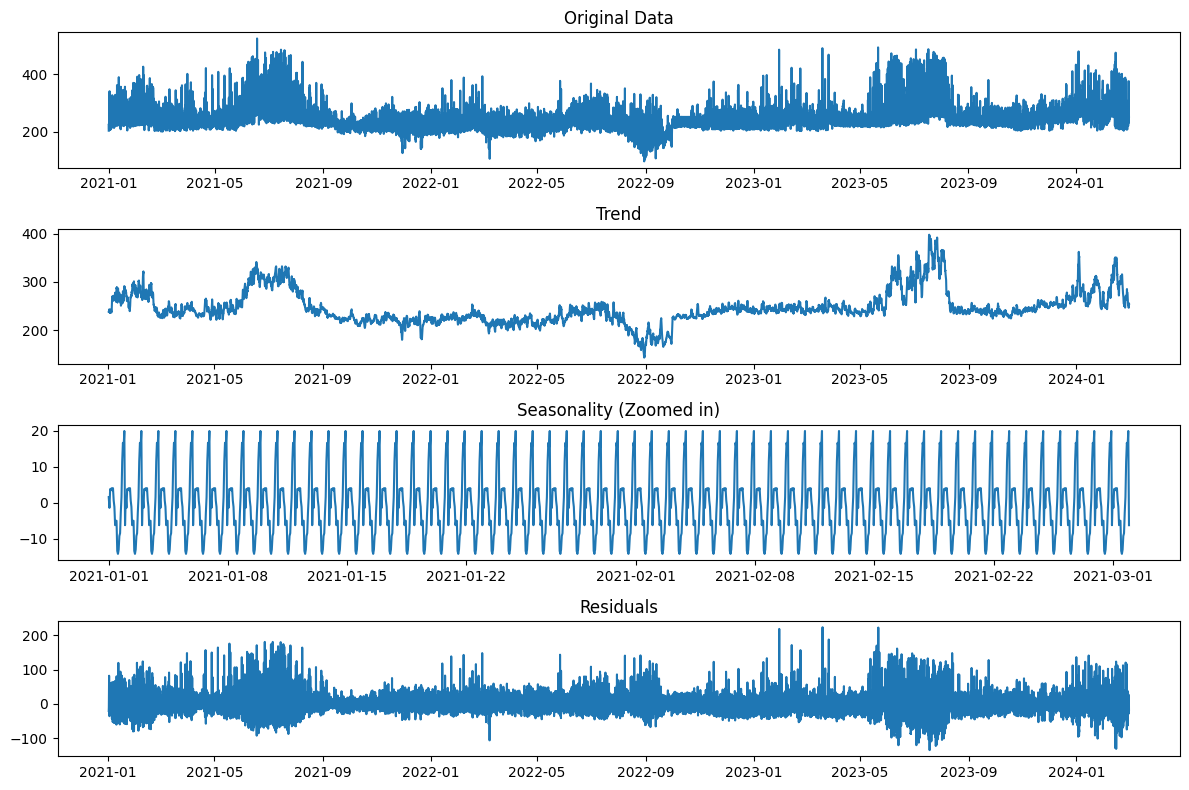

In [ ]:
moer_no.index = pd.DatetimeIndex(moer_no.index)

decomposition = seasonal_decompose(moer_no['moer'], model='additive')
seasonal_subset = decomposition.seasonal.iloc[:1440]

plt.figure(figsize=(12, 8))
plt.xlim('2022-10-01', '2023-12-31')

plt.subplot(4, 1, 1)
plt.plot(moer_no['moer'])
plt.title('Original Data')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(seasonal_subset)
plt.title('Seasonality (Zoomed in)')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
# plt.savefig(figures_path + 'moer_decomposition_NO.png', bbox_inches='tight')
plt.show()

<Figure size 1400x700 with 0 Axes>

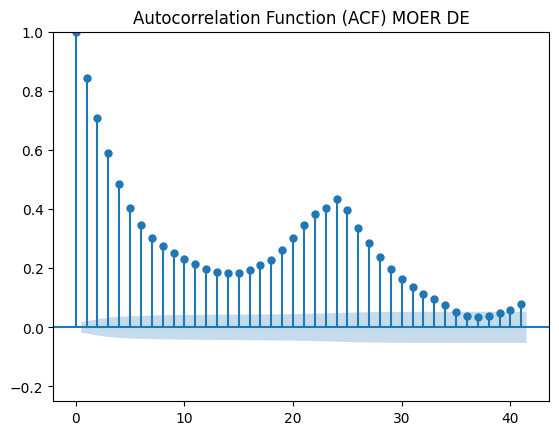

In [ ]:
# ACF DE
plt.figure(figsize=(14, 7))
plot_acf(moer_de['moer'])
plt.ylim(-0.25,1)
plt.title('Autocorrelation Function (ACF) MOER DE')
plt.show()

<Figure size 1400x700 with 0 Axes>

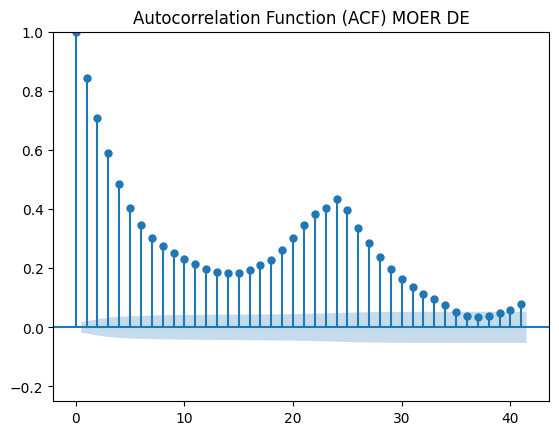

<Figure size 1400x700 with 0 Axes>

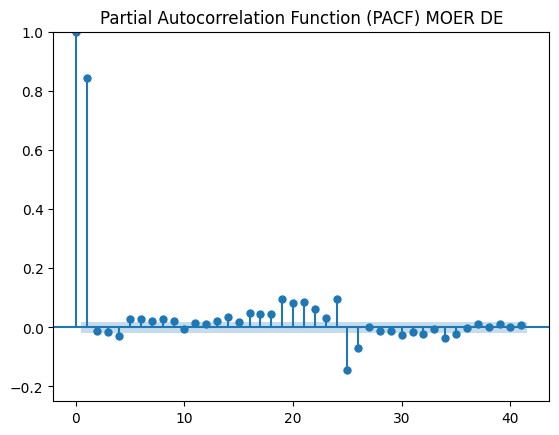

In [ ]:
start_date = pd.to_datetime('2023-09-01 00:00')
training_cutoff_date = pd.to_datetime('2024-02-22 23:00')
de = moer_de.copy()
no = moer_no.copy()
de.index = pd.to_datetime(de.index)
no.index = pd.to_datetime(no.index)
train_de = de[(de.index >= start_date) & (de.index <= training_cutoff_date)]
train_no = no[(no.index >= start_date) & (no.index <= training_cutoff_date)]

# ACF DE
plt.figure(figsize=(14, 7))
plot_acf(de['moer'])
plt.ylim(-0.25,1)
plt.title('Autocorrelation Function (ACF) MOER DE')
plt.show()

# PACF DE
plt.figure(figsize=(14, 7))
plot_pacf(moer_de['moer'])
plt.ylim(-0.25,1)
plt.title('Partial Autocorrelation Function (PACF) MOER DE')
plt.show()

<Figure size 1400x700 with 0 Axes>

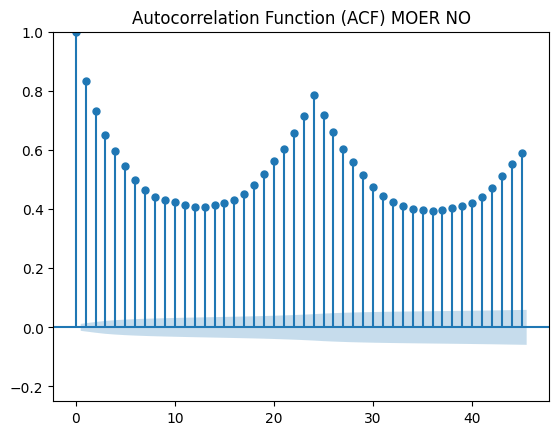

In [ ]:
# ACF NO
plt.figure(figsize=(14, 7))
plot_acf(moer_no['moer'])
plt.ylim(-0.25,1)
plt.title('Autocorrelation Function (ACF) MOER NO')
plt.show()

<Figure size 1400x700 with 0 Axes>

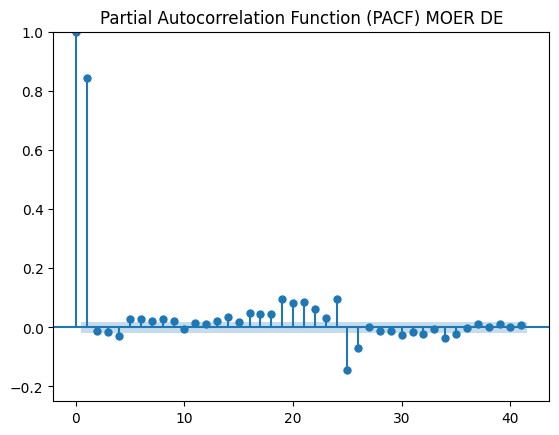

In [ ]:
# PACF DE
plt.figure(figsize=(14, 7))
plot_pacf(moer_de['moer'])
plt.ylim(-0.25,1)
plt.title('Partial Autocorrelation Function (PACF) MOER DE')
plt.show()

<Figure size 1400x700 with 0 Axes>

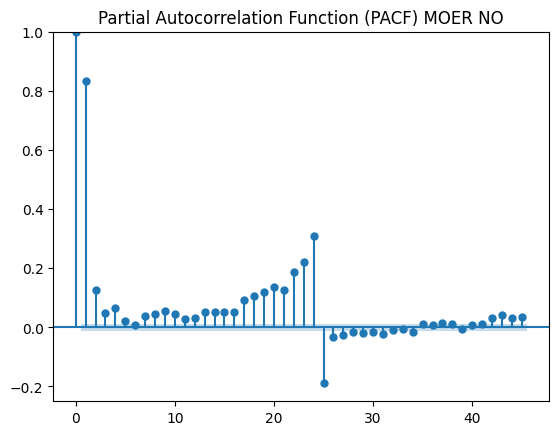

In [ ]:
# PACF NO
plt.figure(figsize=(14, 7))
plot_pacf(moer_no['moer'])
plt.ylim(-0.25,1)
plt.title('Partial Autocorrelation Function (PACF) MOER NO')
plt.show()

Correlation MOER and Features

<ipython-input-12-6eee67135f34>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


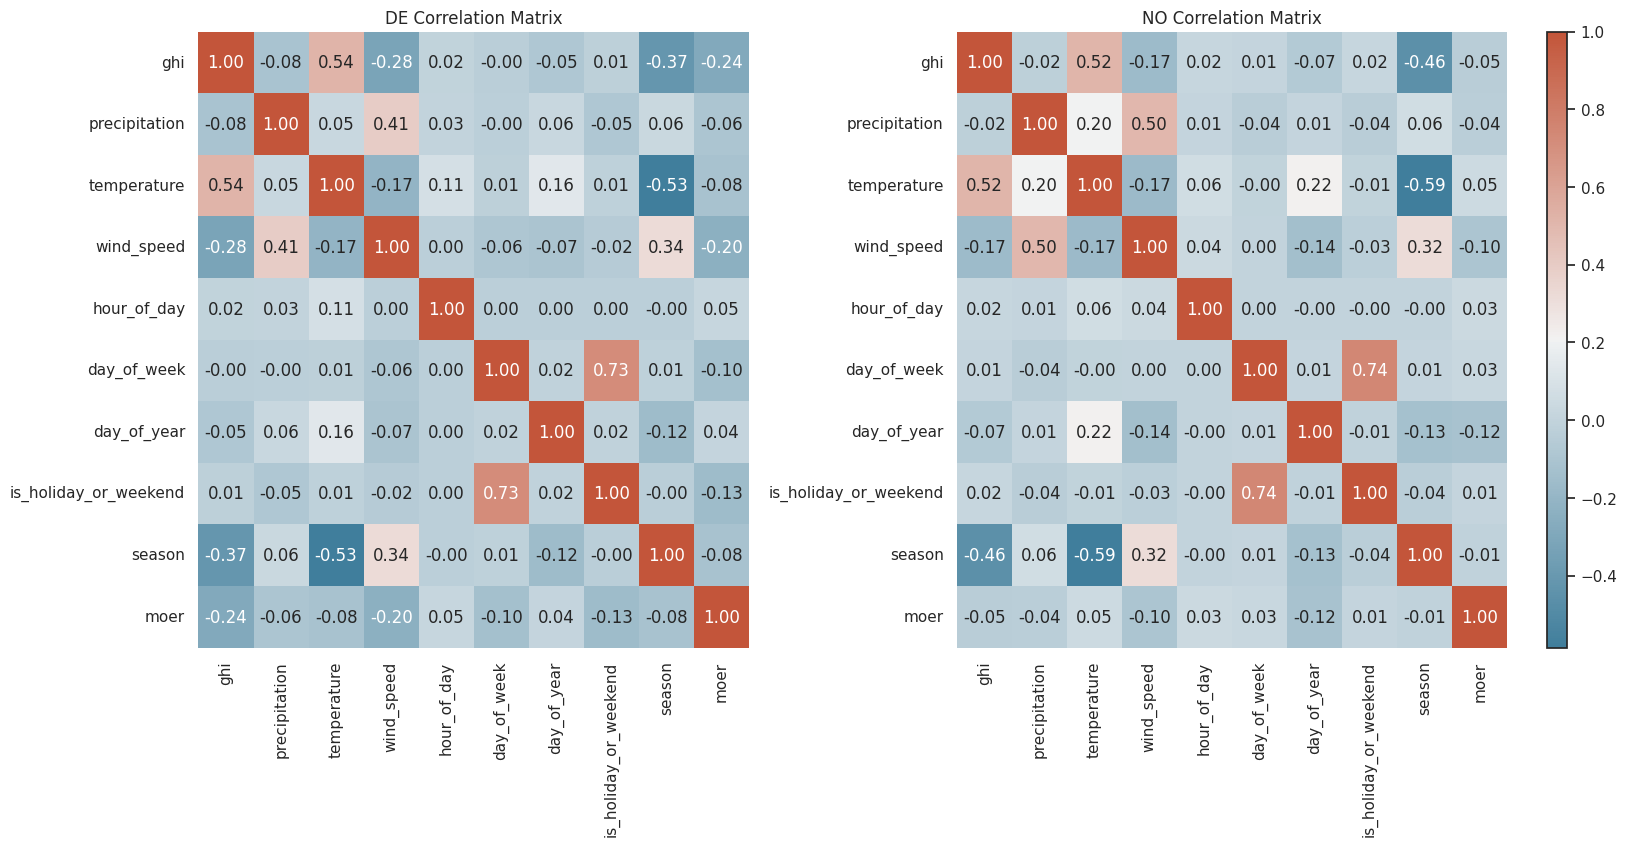

In [ ]:
weather_time_moer_de = weather_time_moer[weather_time_moer['country'] == "DE"]
weather_time_moer_no = weather_time_moer[weather_time_moer['country'] == "NO"]

de_corr = weather_time_moer_de.select_dtypes(include=[np.number]).corr()
no_corr = weather_time_moer_no.select_dtypes(include=[np.number]).corr()

sns.set_theme(style="white")

fig = plt.figure(figsize=(20, 8))

gs = GridSpec(1, 3, width_ratios=[1, 1, 0.06], wspace=0.55, hspace=0.0)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(de_corr, annot=True, fmt=".2f", cmap=cmap, ax=ax1, cbar=False)
ax1.set_title('DE Correlation Matrix')

sns.heatmap(no_corr, annot=True, fmt=".2f", cmap=cmap, ax=ax2, cbar=False)
ax2.set_title('NO Correlation Matrix')

cbar_ax = fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y0, 0.01, ax2.get_position().height])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(de_corr.min().min(), no_corr.min().min()), vmax=max(de_corr.max().max(), no_corr.max().max())))
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout()

# plt.savefig(figures_path + 'correlation_matrix.png', bbox_inches='tight')
plt.show()

<ipython-input-25-b53568c219e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_time_moer_DE['hour'] = weather_time_moer_DE.index.hour
<ipython-input-25-b53568c219e9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_time_moer_DE['day'] = weather_time_moer_DE.index.dayofyear


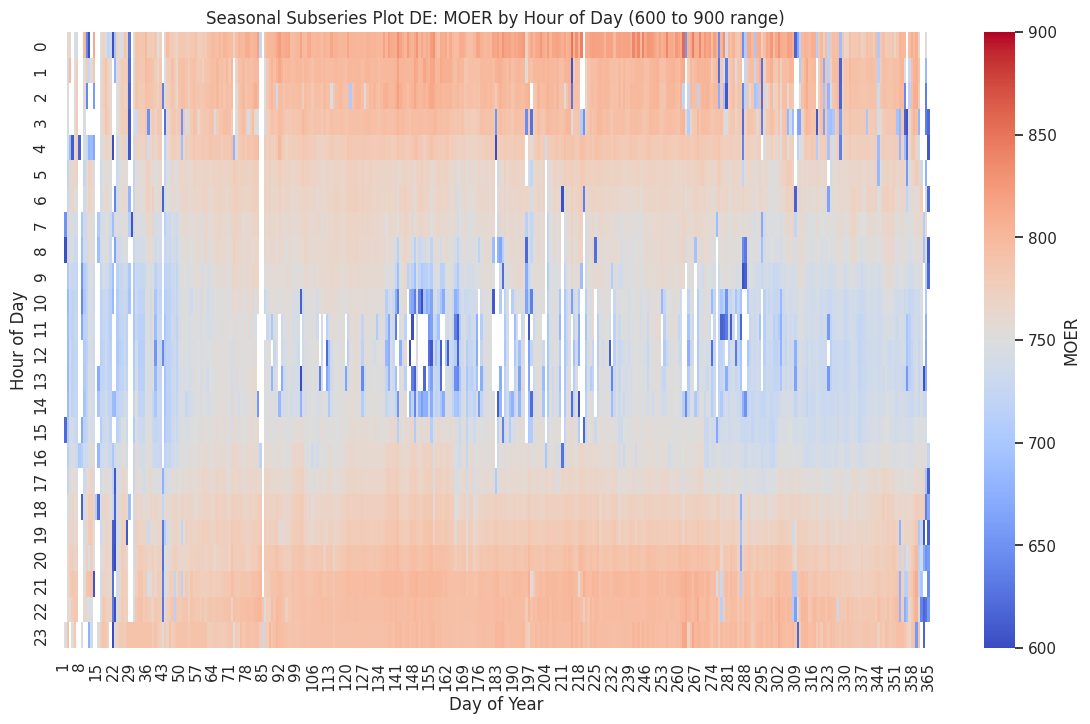

In [ ]:
weather_time_moer_DE.index = pd.to_datetime(weather_time_moer_DE.index)
weather_time_moer_DE['hour'] = weather_time_moer_DE.index.hour
weather_time_moer_DE['day'] = weather_time_moer_DE.index.dayofyear

pivot_table = weather_time_moer_DE.pivot_table(values='moer', index='hour', columns='day', aggfunc='mean')
pivot_table_filtered = pivot_table.applymap(lambda x: x if 600 <= x <= 900 else np.nan)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table_filtered, cmap='coolwarm', cbar_kws={'label': 'MOER'}, vmin=600, vmax=900)
plt.title('Seasonal Subseries Plot DE: MOER by Hour of Day (600 to 900 range)')
plt.xlabel('Day of Year')
plt.ylabel('Hour of Day')
plt.show()

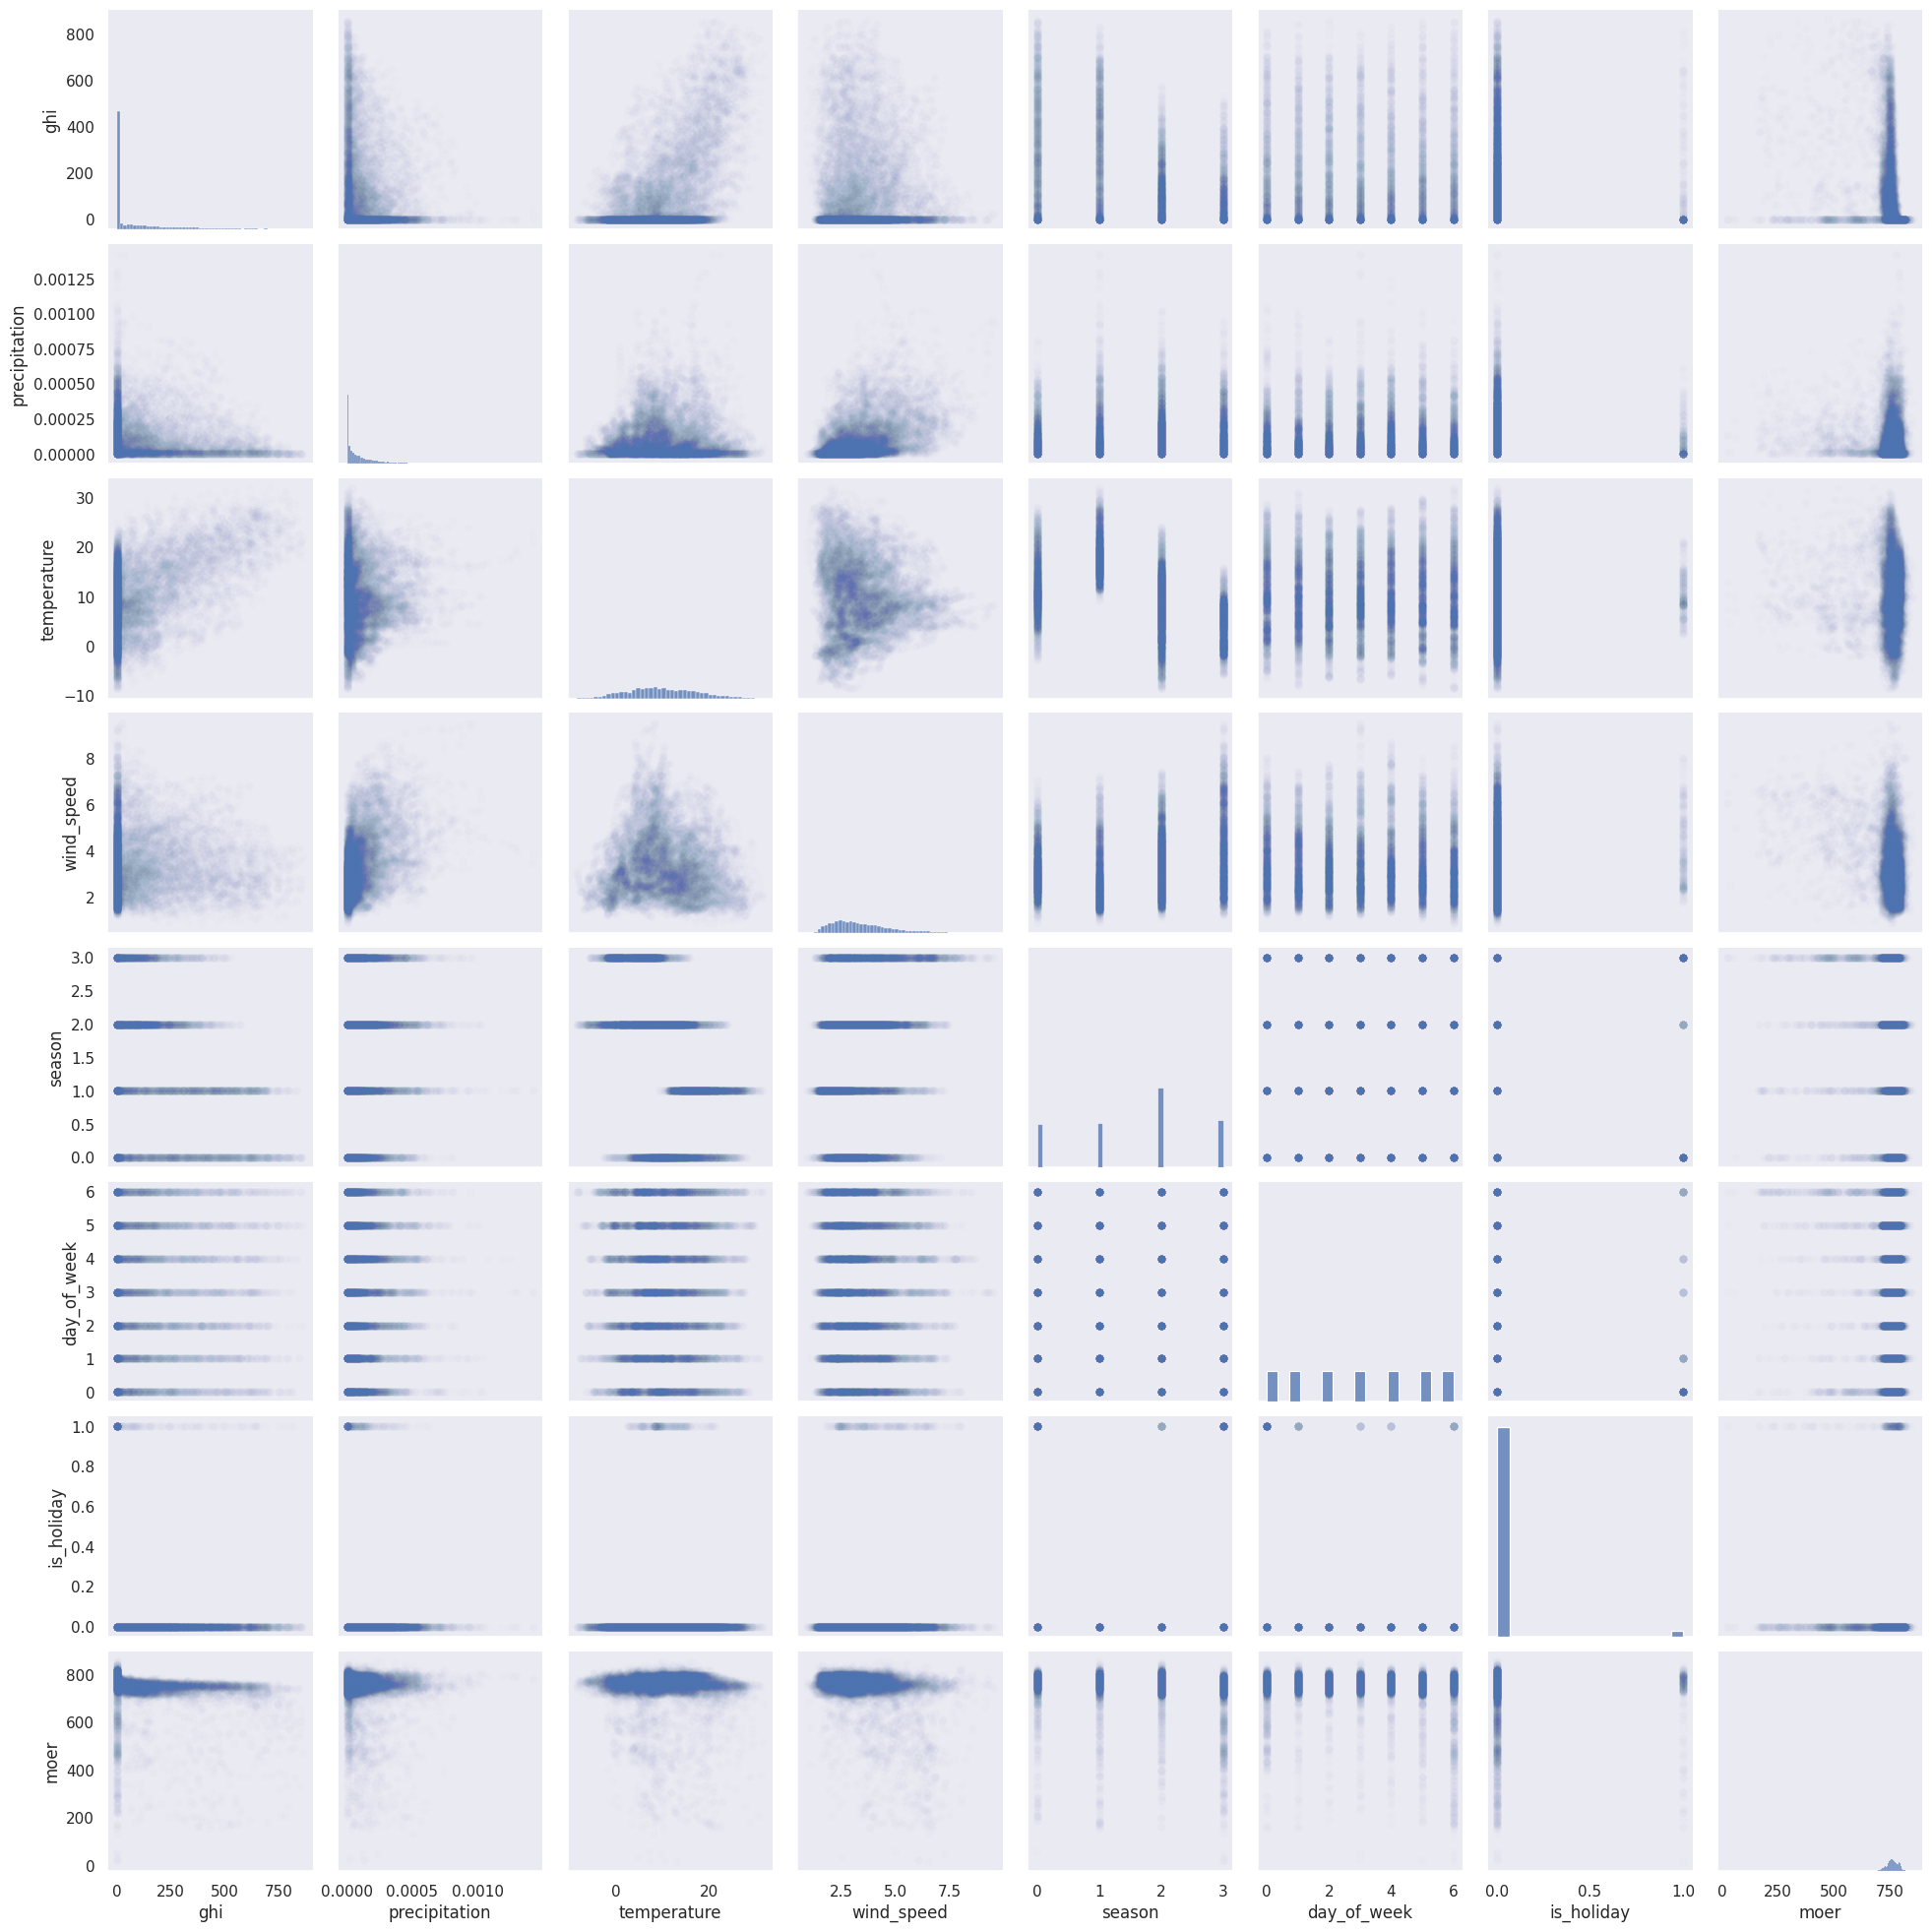

In [ ]:
sns.pairplot(weather_time_moer_DE, kind='scatter', plot_kws={'alpha': 0.01})

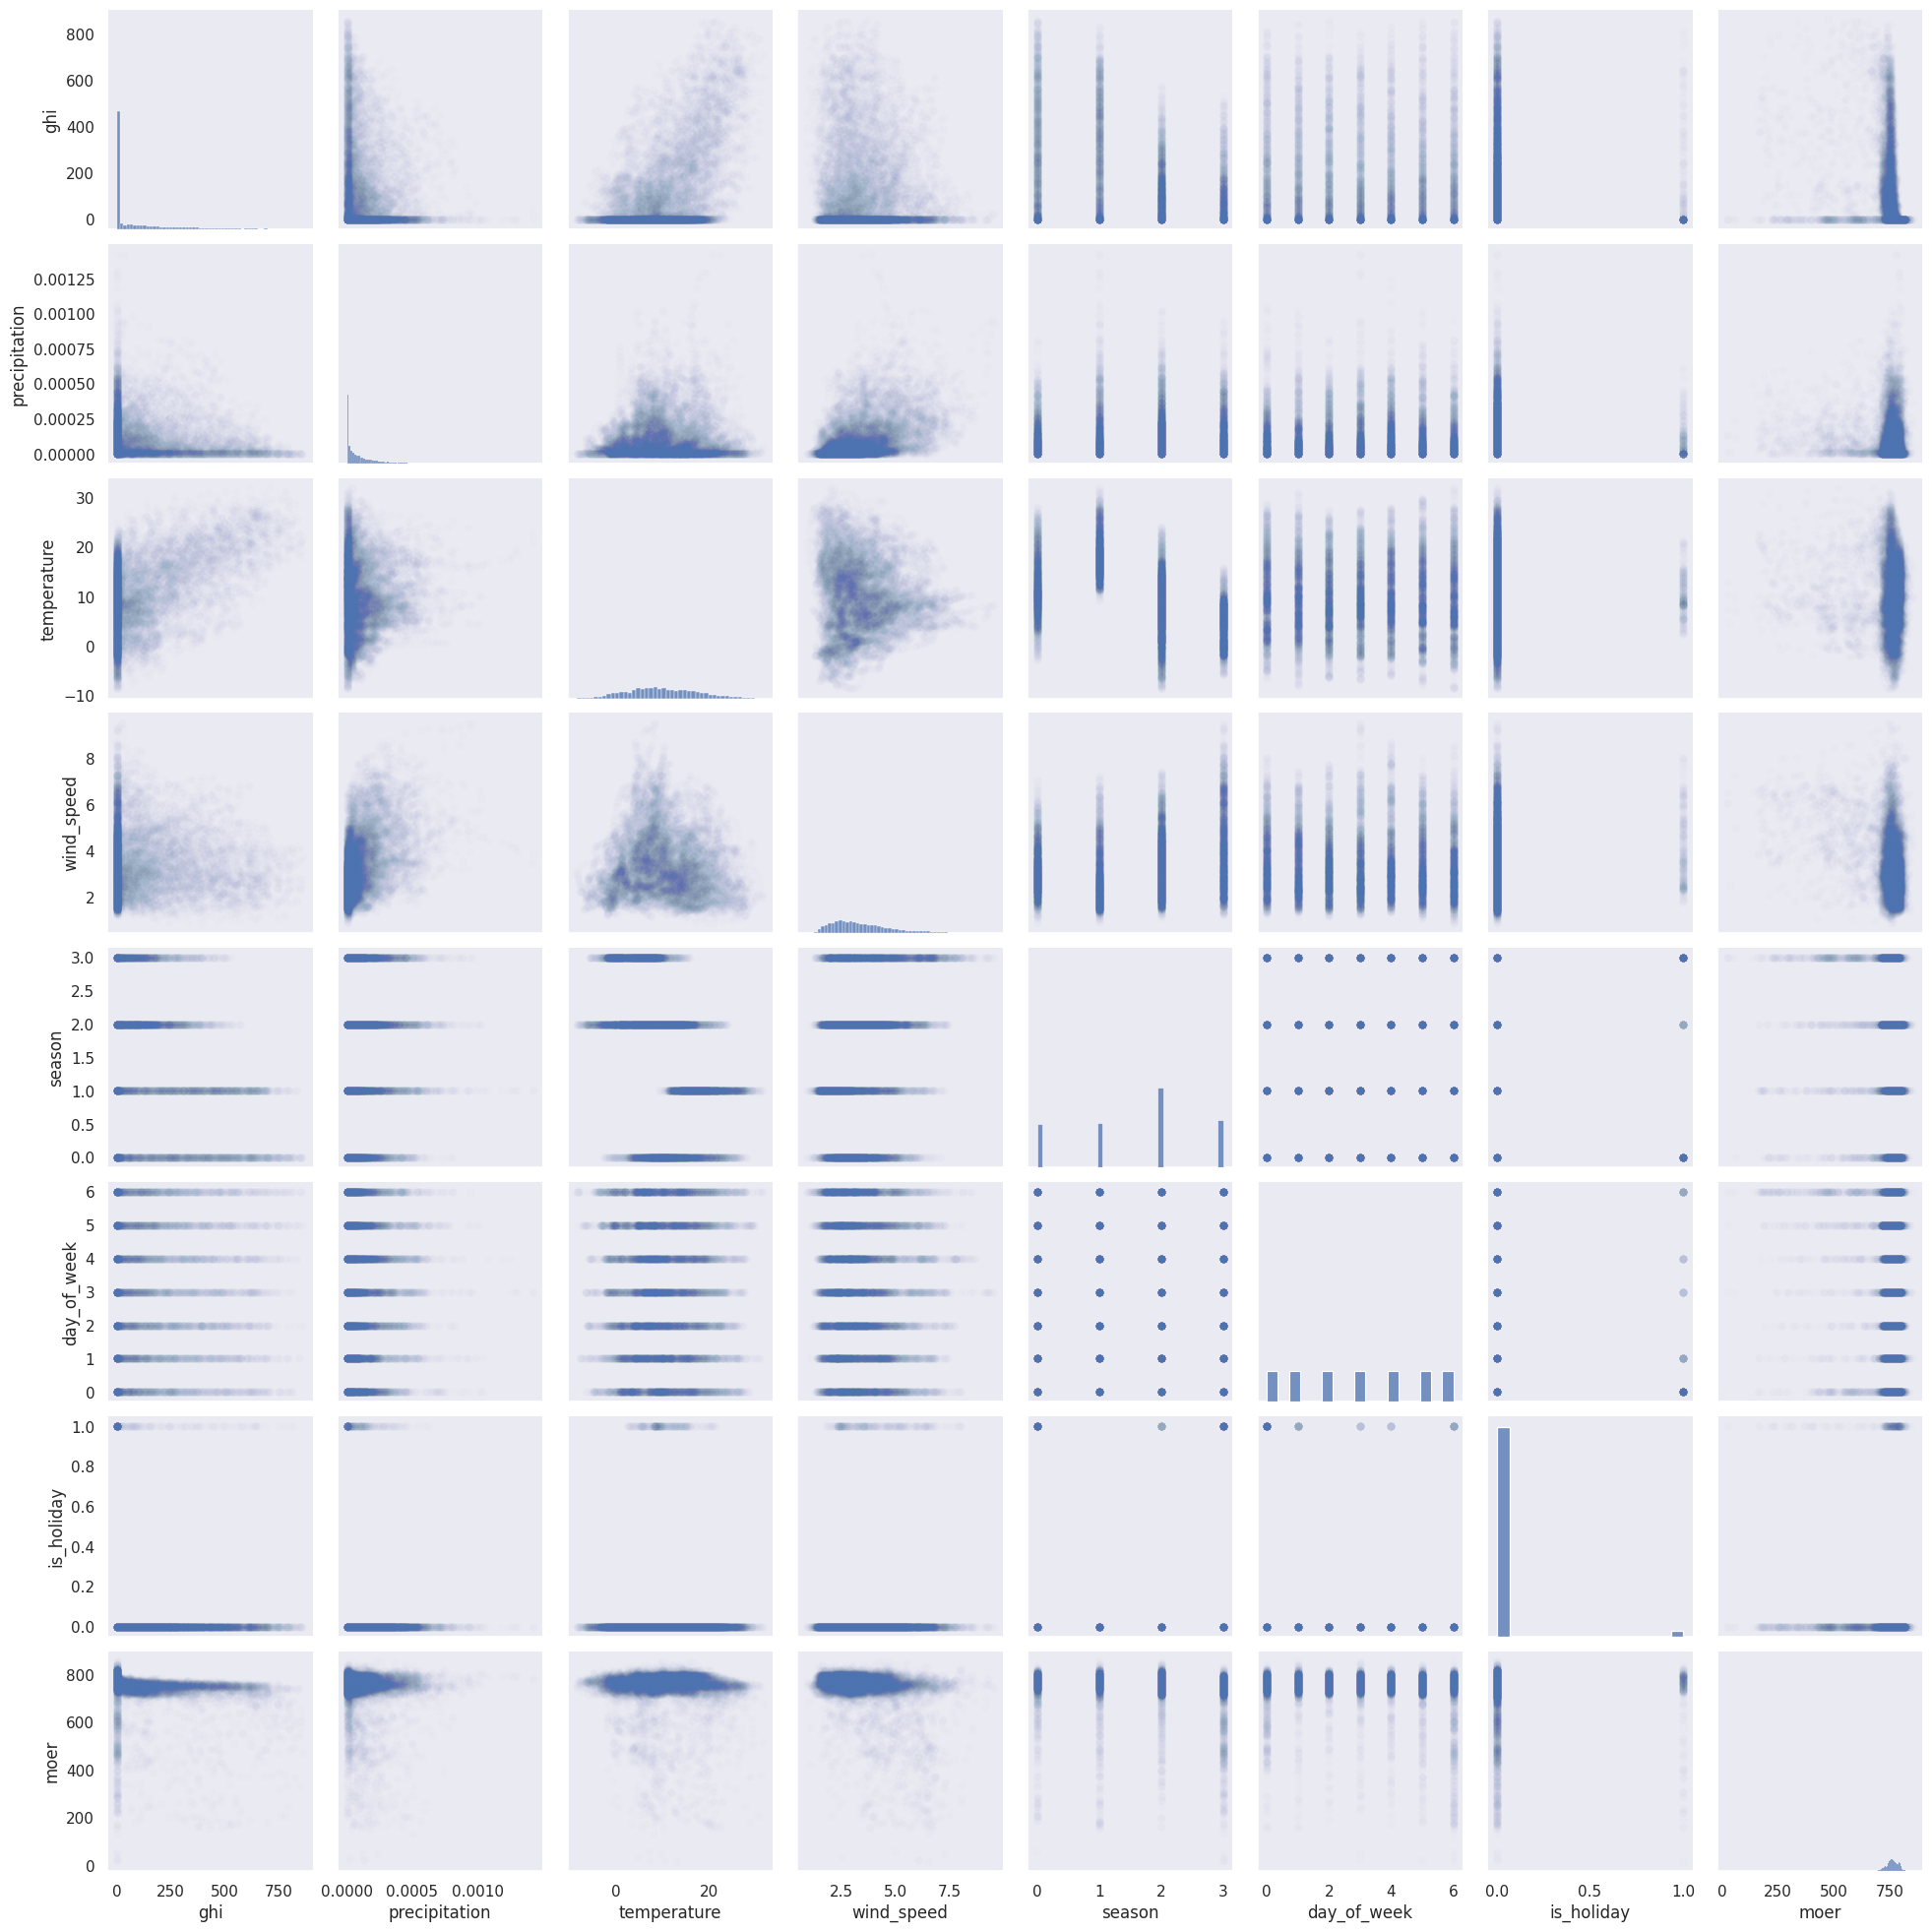

In [ ]:
sns.pairplot(weather_time_moer_DE, kind='scatter', plot_kws={'alpha': 0.01})

Days of Week analysis

In [ ]:
for df in [moer_de, moer_no]:
    df.index = pd.DatetimeIndex(df.index)
    x = df.copy()
    x['day_type'] = pd.Series(x.index).dt.dayofweek.apply(lambda d: 'workday' if d < 5 else 'weekend').values
    grouped = x.groupby(['day_type', x.index.hour]).median()

    workdays = grouped.loc['workday']
    weekend = grouped.loc['weekend']

    workdays_mean = workdays.mean().values
    weekend_mean = weekend.mean().values
    difference = (1 - weekend_mean / workdays_mean) * 100

    print(workdays_mean)
    print(weekend_mean)
    print(f"{difference[0]:.2f}%")

[768.18687399]
[764.57625017]
0.47%
[237.04072181]
[238.43031981]
-0.59%


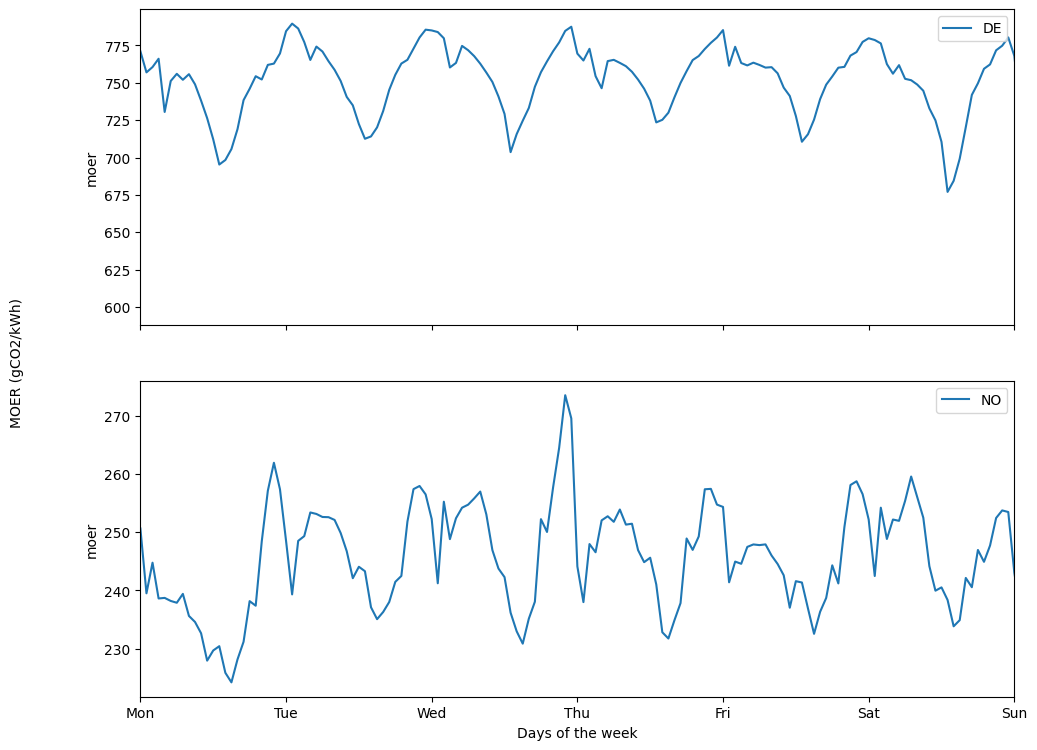

In [ ]:
de_tz = pytz.timezone('Europe/Berlin')
no_tz = pytz.timezone('Europe/Oslo')

f, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10, 8))
f.tight_layout(pad=3)
f.text(-0.05, 0.5, "MOER (gCO2/kWh)", ha="center", va="center", rotation="vertical")

for df, ax, country in zip([moer_de.copy(), moer_no.copy()], axs.flatten(), ['DE', 'NO']):
    df.index = pd.DatetimeIndex(df.index)
    df.index = df.index.tz_localize('UTC').tz_convert(de_tz if country == 'DE' else no_tz)
    df['time'] = df.index.dayofweek * 24 * 60 + df.index.hour * 60

    sns.lineplot(data=df, x="time", y="moer", errorbar=None, ax=ax, label=country)
    ax.set_xlim(0, 1440 * 6)

    ticks = range(0, 7 * 24 * 60, 24 * 60)
    tick_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)

axs[-1].set_xlabel("Days of the week")
f.align_ylabels(axs)
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

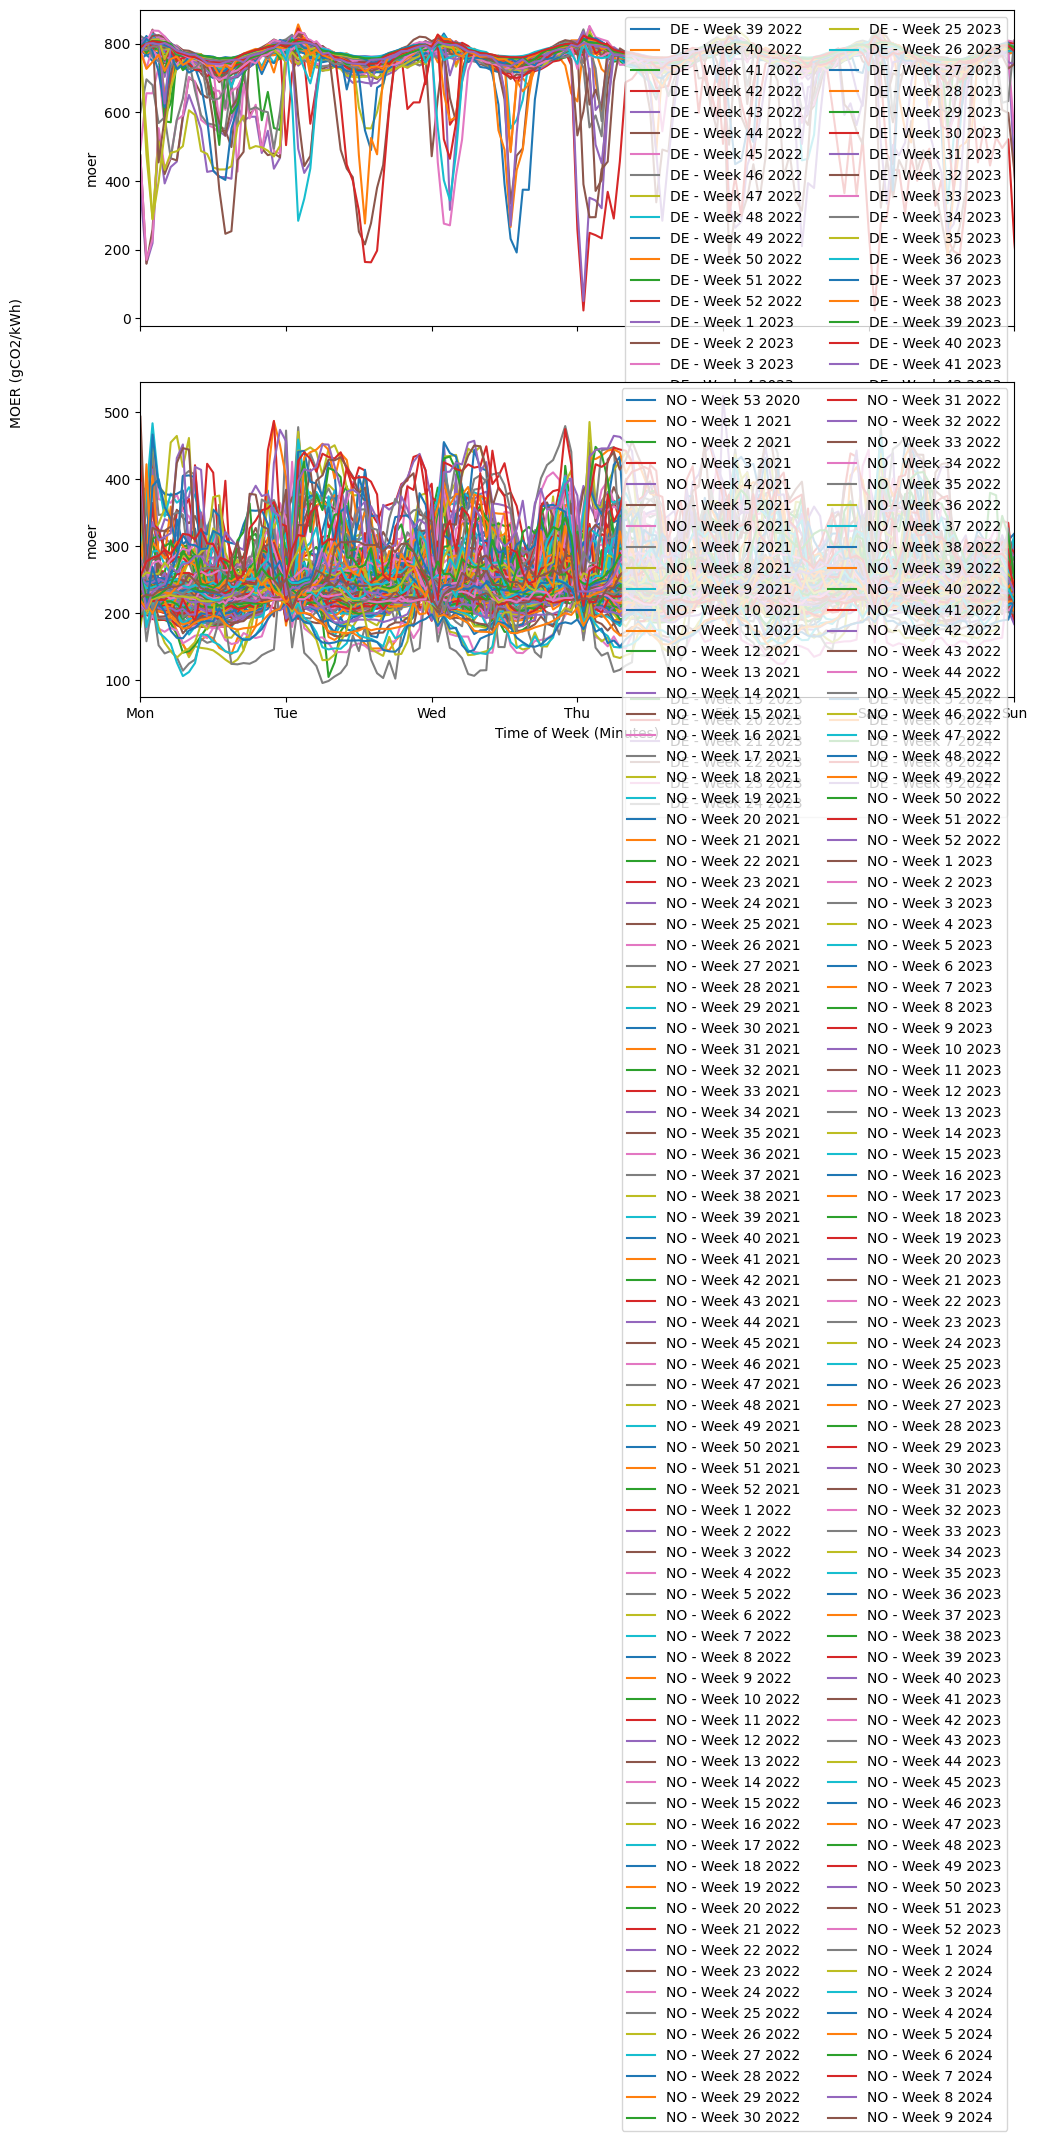

In [ ]:
de_tz = pytz.timezone('Europe/Berlin')
no_tz = pytz.timezone('Europe/Oslo')

f, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10, 8))
f.tight_layout(pad=3)
f.text(-0.05, 0.5, "MOER (gCO2/kWh)", ha="center", va="center", rotation="vertical")

for df, ax, country in zip([moer_de.copy(), moer_no.copy()], axs.flatten(), ['DE', 'NO']):
    df.index = pd.DatetimeIndex(df.index)
    tz = de_tz if country == 'DE' else no_tz
    df.index = df.index.tz_localize('UTC').tz_convert(tz)

    # Create a 'week' column to identify the weeks
    df['week'] = df.index.isocalendar().week
    df['year'] = df.index.isocalendar().year
    df['time'] = df.index.dayofweek * 24 * 60 + df.index.hour * 60

    # Group by year and week, and plot each group as a separate line
    for (year, week), group in df.groupby(['year', 'week']):
        # Create a label for the line that includes the year and week number
        label = f'{country} - Week {week} {year}'
        sns.lineplot(data=group, x="time", y="moer", ax=ax, label=label)

    ax.set_xlim(0, 1440 * 6)
    ticks = range(0, 7 * 24 * 60, 24 * 60)
    tick_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)

axs[-1].set_xlabel("Time of Week (Minutes)")
f.align_ylabels(axs)
axs[0].legend(loc='upper right', ncol=2) # Adjust legend columns
axs[1].legend(loc='upper right', ncol=2)

plt.show()

Shifting potential

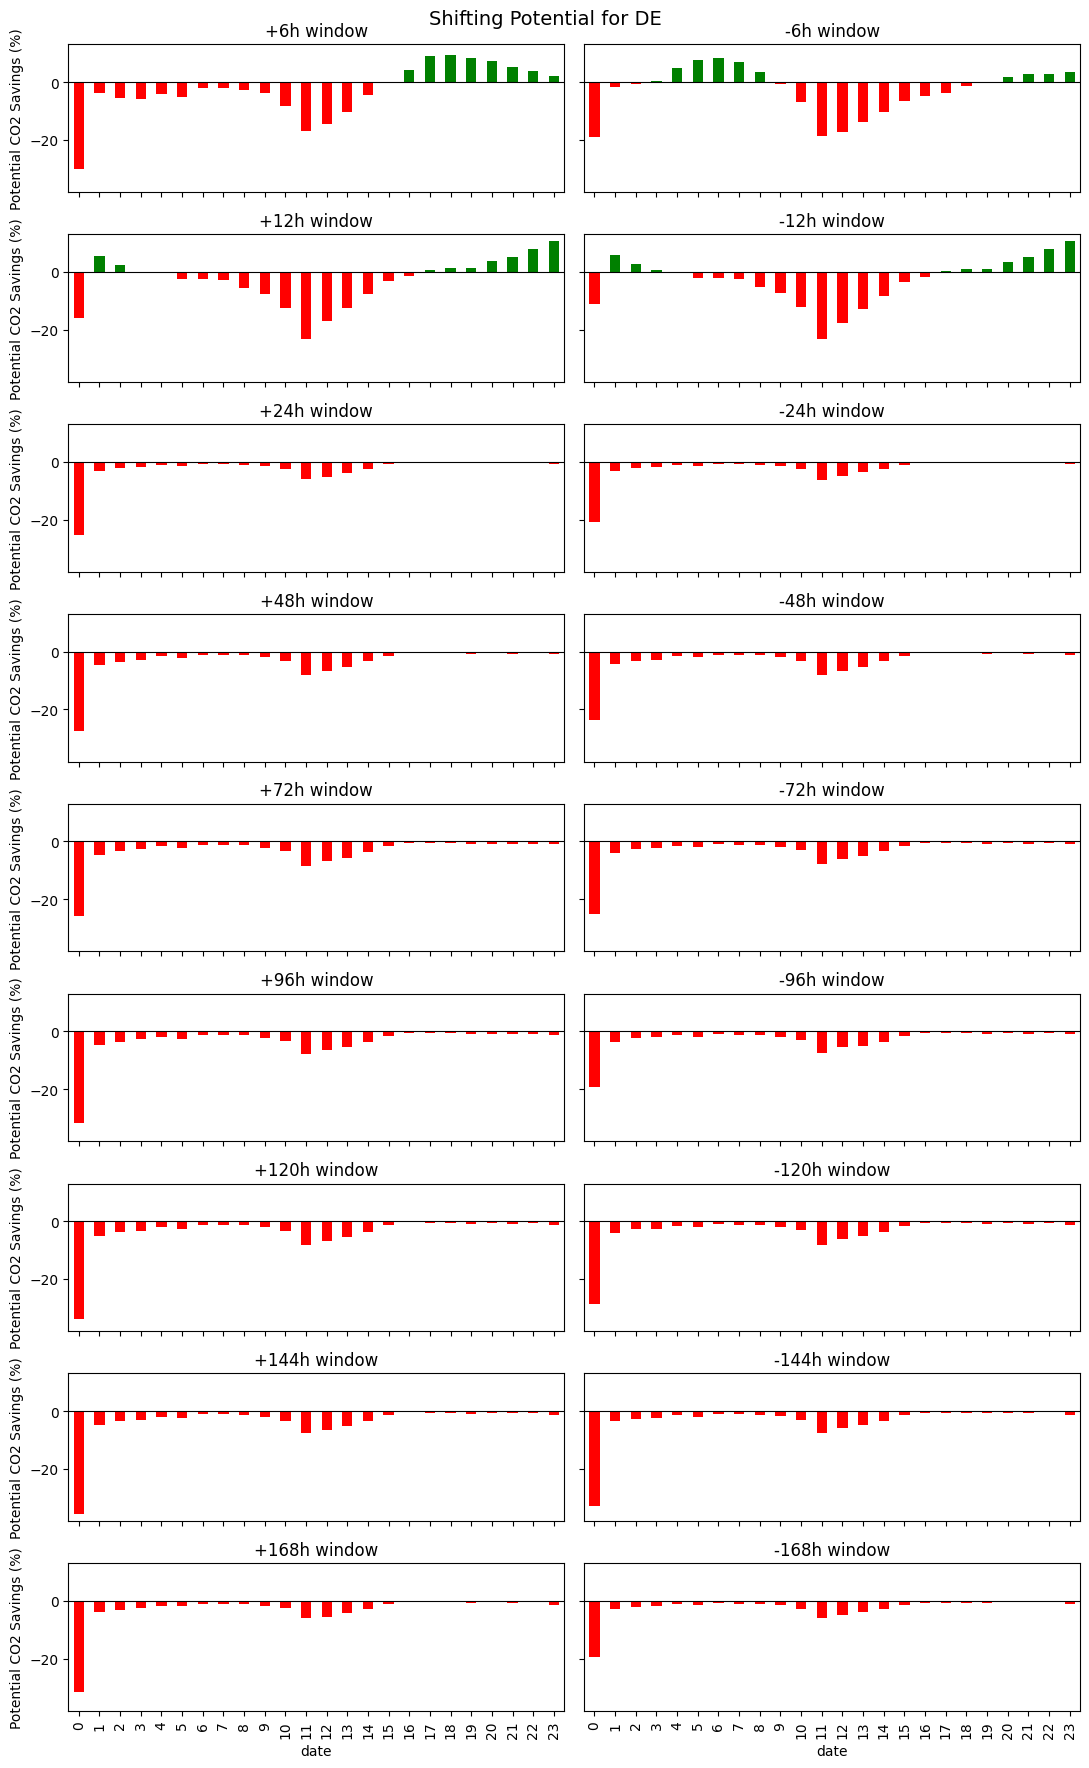

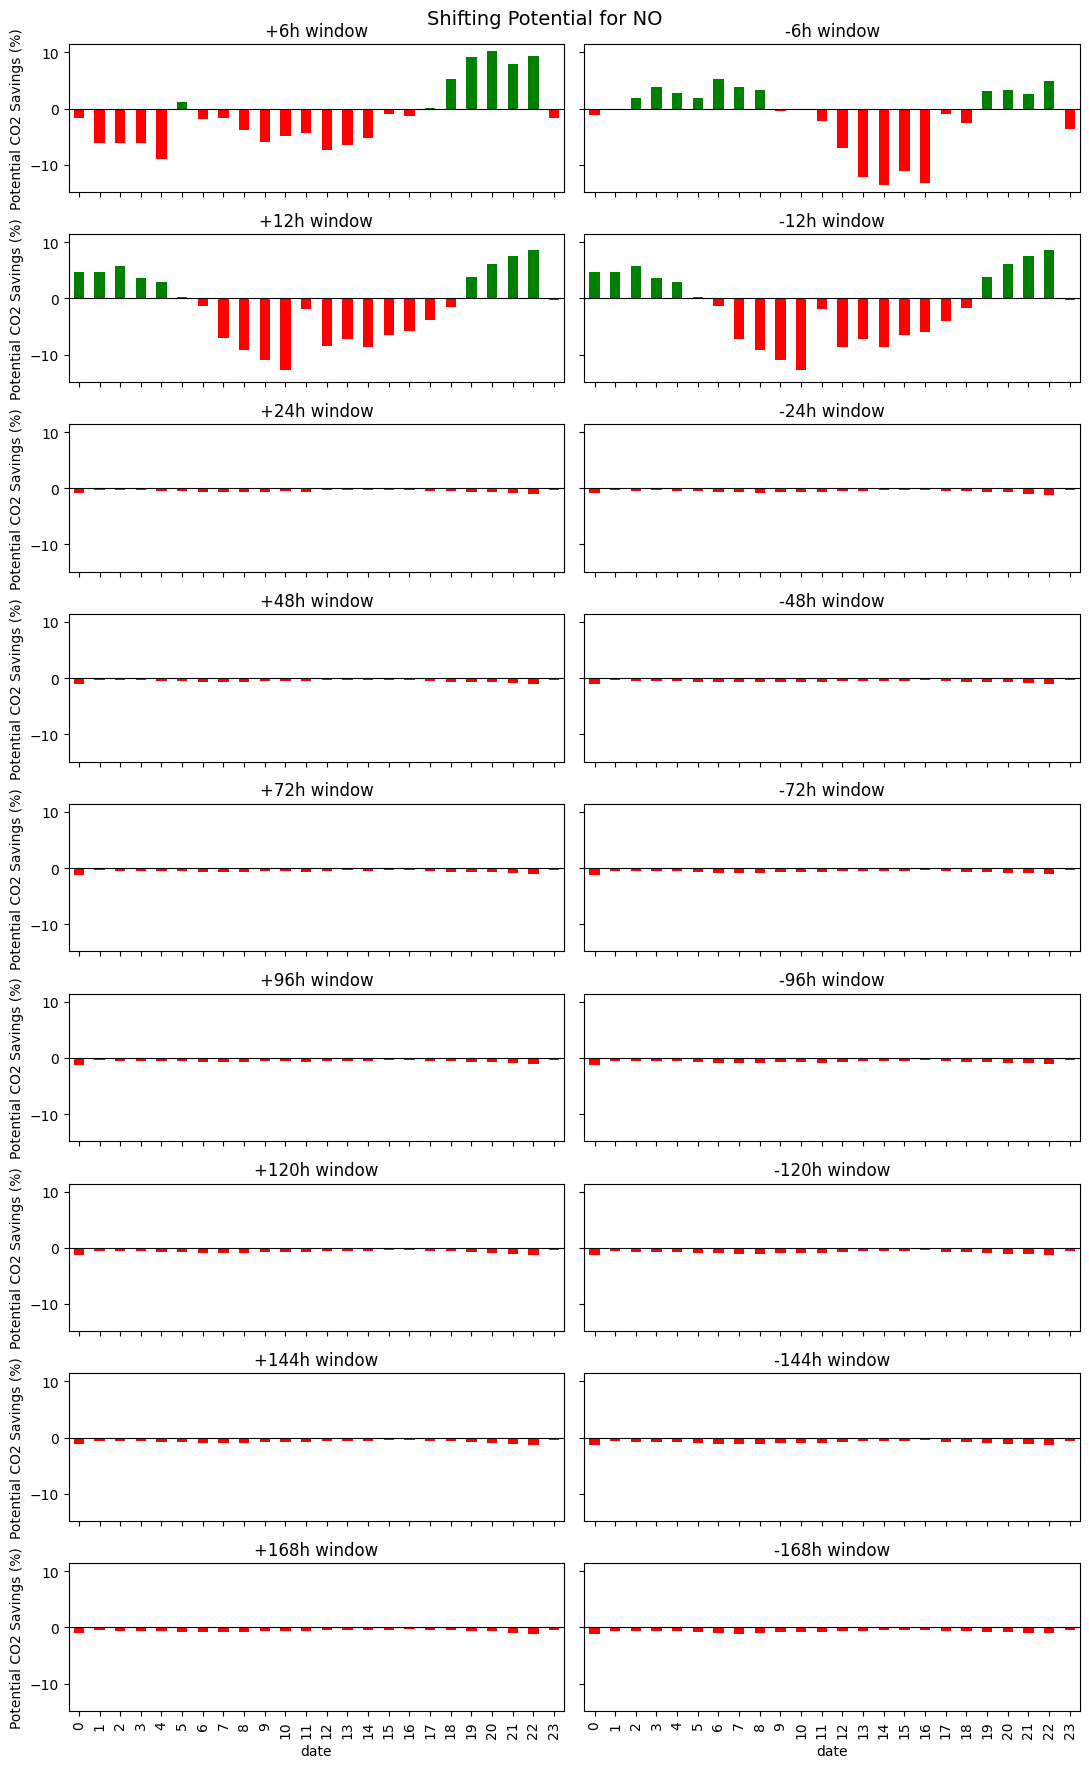

In [ ]:
date_ranges = {
    'DE': ('2022-10-01 00:00:00', '2024-02-29 23:00:00'),
    'NO': ('2021-01-01 00:00:00', '2024-02-29 23:00:00')
}

# Lookahead intervals in hours
lookahead_windows = [6, 12, 24, 48, 72, 96, 120, 144, 168]  # 6h, 12h, 1d, 2d, 3d, 4d, 5d, 6d, 1w
countries_data = {'DE': moer_de.copy(), 'NO': moer_no.copy()}

def calculate_shifting_potential(df, hours_lookahead, plus=True):
    shifted_values = df['moer'].shift(periods=hours_lookahead if plus else -hours_lookahead)
    shifted_values.fillna(df['moer'], inplace=True)
    potential_savings = df['moer'] - shifted_values
    potential_savings_percentage = (potential_savings / df['moer']) * 100
    return potential_savings_percentage

def best_time_of_day_graph(df, ax, start_date, end_date, hours_lookahead, plus=True):
    df_filtered = df[start_date:end_date]
    shifting_potential_percentage = calculate_shifting_potential(df_filtered, hours_lookahead, plus)
    groupby_hour = shifting_potential_percentage.groupby(df_filtered.index.hour).mean()

    colors = ['green' if x >= 0 else 'red' for x in groupby_hour]
    groupby_hour.plot(kind='bar', ax=ax, color=colors)
    ax.set_title(f"{('+' if plus else '-')}{hours_lookahead}h window")
    ax.set_ylabel('Potential CO2 Savings (%)')
    ax.axhline(0, color='black', linewidth=0.8)

for country, data in countries_data.items():
    data.index = pd.to_datetime(data.index)
    n_rows = len(lookahead_windows)
    n_cols = 2

    f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(11, 2 * n_rows), sharex=True, sharey=True)
    f.suptitle(f"Shifting Potential for {country}", fontsize=14)

    global_min, global_max = None, None

    for row_idx, lookahead in enumerate(lookahead_windows):
        for col_idx, plus in enumerate([True, False]):
            ax = axs[row_idx][col_idx]
            best_time_of_day_graph(data, ax, date_ranges[country][0], date_ranges[country][1], lookahead, plus)

    plt.tight_layout()
    plt.show()

In [ ]:
start_date = '2022-10-01'
end_date = '2024-02-29'
df_de_filtered = moer_de[start_date:end_date]
df_no_filtered = moer_no[start_date:end_date]

df_de_filtered.index = pd.to_datetime(df_de_filtered.index)
df_no_filtered.index = pd.to_datetime(df_no_filtered.index)

if not df_de_filtered.index.equals(df_no_filtered.index):
    df_no_filtered = df_no_filtered.reindex(df_de_filtered.index)

potential_savings_de_to_no = (df_de_filtered['moer'] - df_no_filtered['moer']) / df_de_filtered['moer'] * 100
potential_savings_no_to_de = (df_no_filtered['moer'] - df_de_filtered['moer']) / df_no_filtered['moer'] * 100

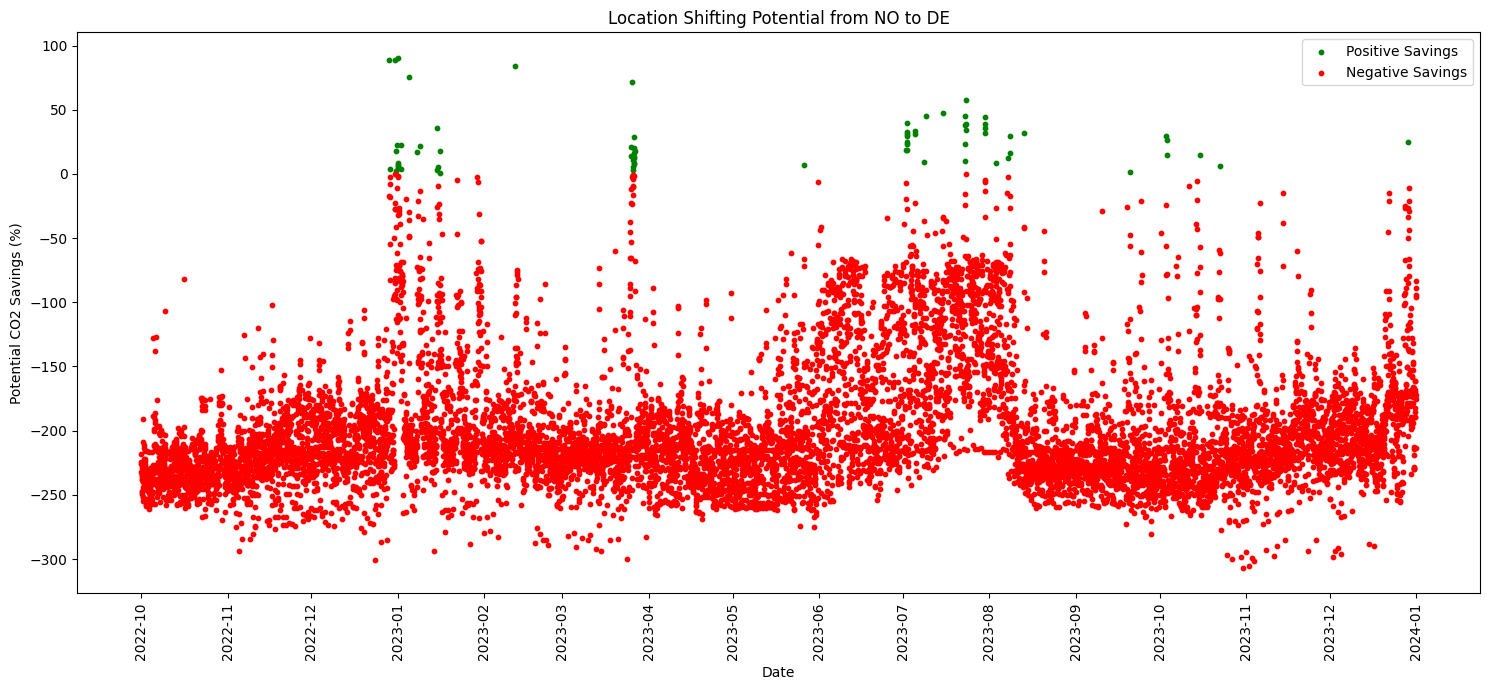

In [ ]:
def plot_savings_with_dates(df, title):
    fig, ax = plt.subplots(figsize=(15, 7))

    mask_positive = df > 0
    mask_negative = df < 0

    ax.scatter(df.index[mask_positive], df[mask_positive], color='green', label='Positive Savings', s=10)
    ax.scatter(df.index[mask_negative], df[mask_negative], color='red', label='Negative Savings', s=10)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=90)

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Potential CO2 Savings (%)')
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_savings_with_dates(potential_savings_no_to_de, 'Location Shifting Potential from NO to DE')

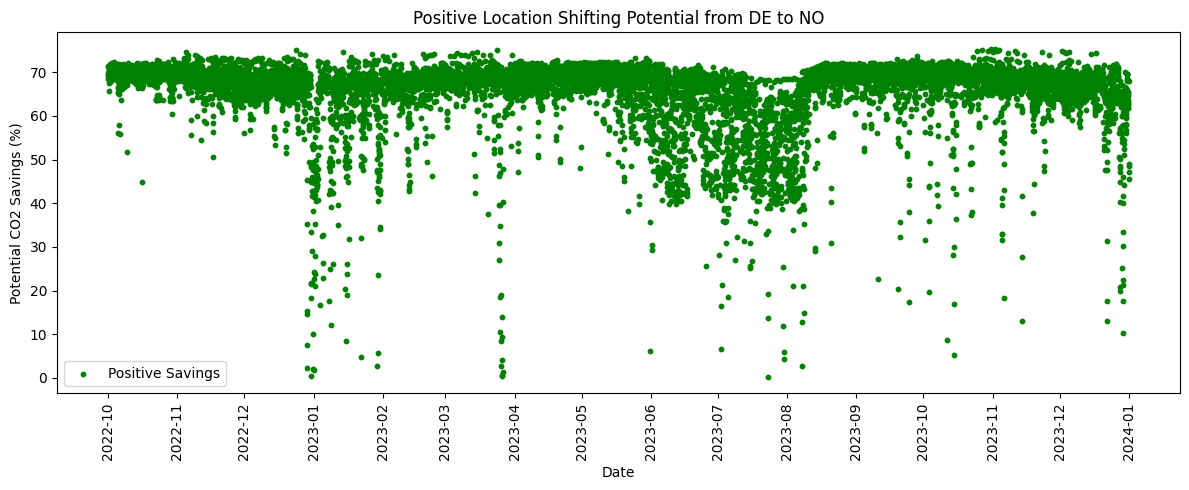

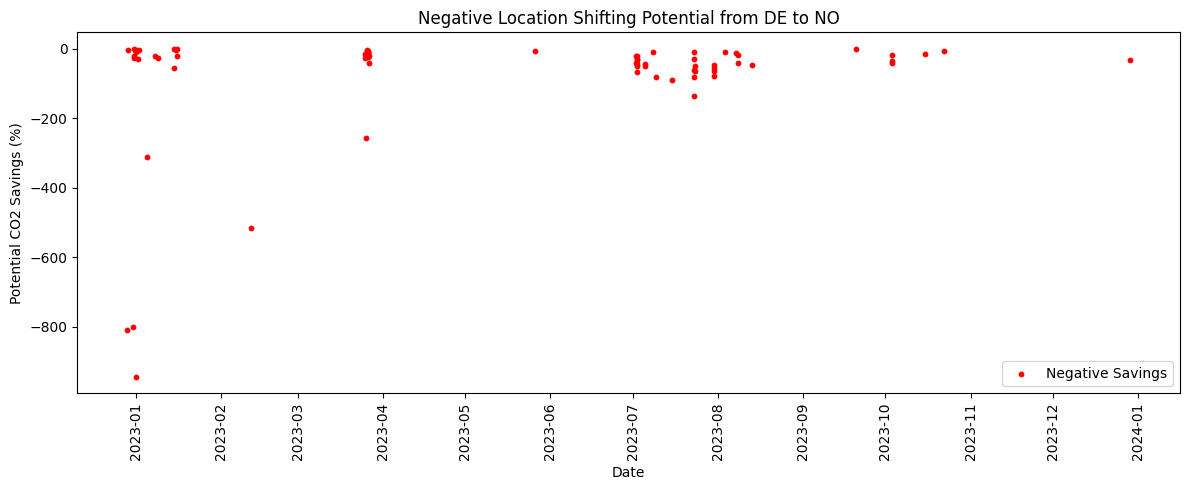

In [ ]:
def plot_savings_with_dates(df, title, positive=True):
    fig, ax = plt.subplots(figsize=(12, 5))

    color = 'green' if positive else 'red'
    label = 'Positive Savings' if positive else 'Negative Savings'

    ax.scatter(df.index, df, color=color, label=label, s=10)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=90)

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Potential CO2 Savings (%)')
    ax.legend()

    plt.tight_layout()
    plt.show()

positive_savings_de_to_no = potential_savings_de_to_no[potential_savings_de_to_no > 0]
negative_savings_de_to_no = potential_savings_de_to_no[potential_savings_de_to_no < 0]

plot_savings_with_dates(positive_savings_de_to_no, 'Positive Location Shifting Potential from DE to NO', positive=True)
plot_savings_with_dates(negative_savings_de_to_no, 'Negative Location Shifting Potential from DE to NO', positive=False)

[Text(106.99999999999999, 0.5, 'MOER\n(gCO2 / kWh)')]

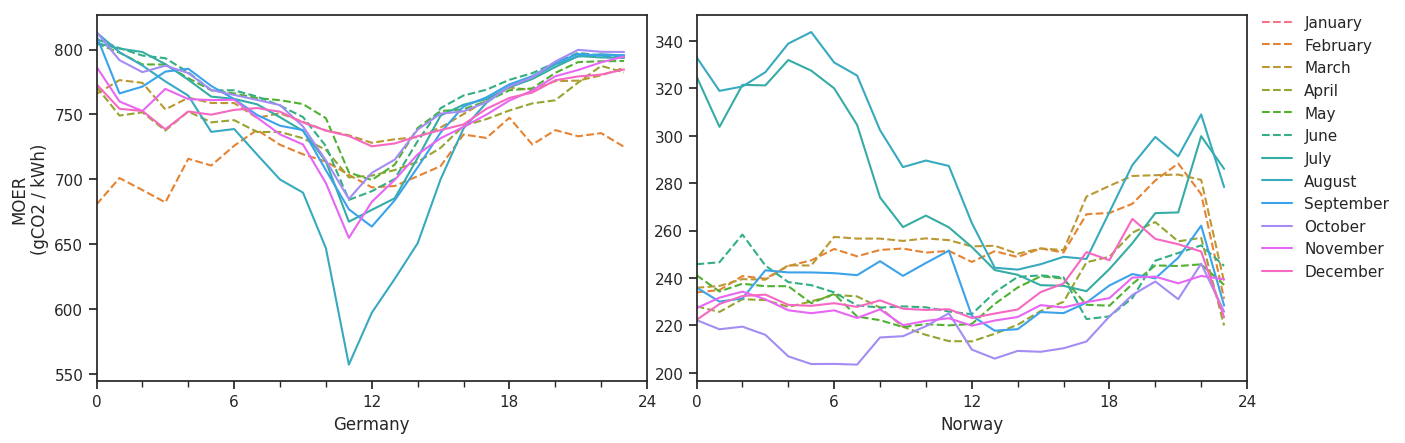

In [ ]:
sns.set_theme(style='ticks')

f, axs = plt.subplots(ncols=2, nrows=1, sharey=False, sharex=True, figsize=(12,4))
f.tight_layout(pad=0)

palette = sns.color_palette("husl", 12)

for ax, s, country in zip(axs, [moer_de, moer_no], ["Germany", "Norway"]):
    x = pd.DataFrame(s)
    x.index = pd.DatetimeIndex(x.index)

    for month, color, linestyle in zip(range(12), palette, ["--"]*6 + ["-"]*6):
        xm = x[x.index.month == month]
        xm = xm.groupby(xm.index.hour * 60 + xm.index.minute).mean(numeric_only=True)
        ax.plot(xm.index, xm['moer'], color=color, linestyle=linestyle, label=month)

    ax.set(xlabel=country)
    ax.set_xlim(0, 1440)
    ticks = range(0, 24*60+1, 60*6)
    minior_ticks = range(0, 24*60+1, 60*2)
    ax.set_xticks(ticks)
    ax.set_xticks(minior_ticks, minor=True)
    ax.set_xticklabels([f"{int(tick/60)}" for tick in ticks])

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], loc='upper right', bbox_to_anchor=(1.12, 1.02), frameon=False)

axs[0].set(ylabel='MOER\n(gCO2 / kWh)')

[Text(106.99999999999999, 0.5, 'MOER\n(gCO2/kWh)')]

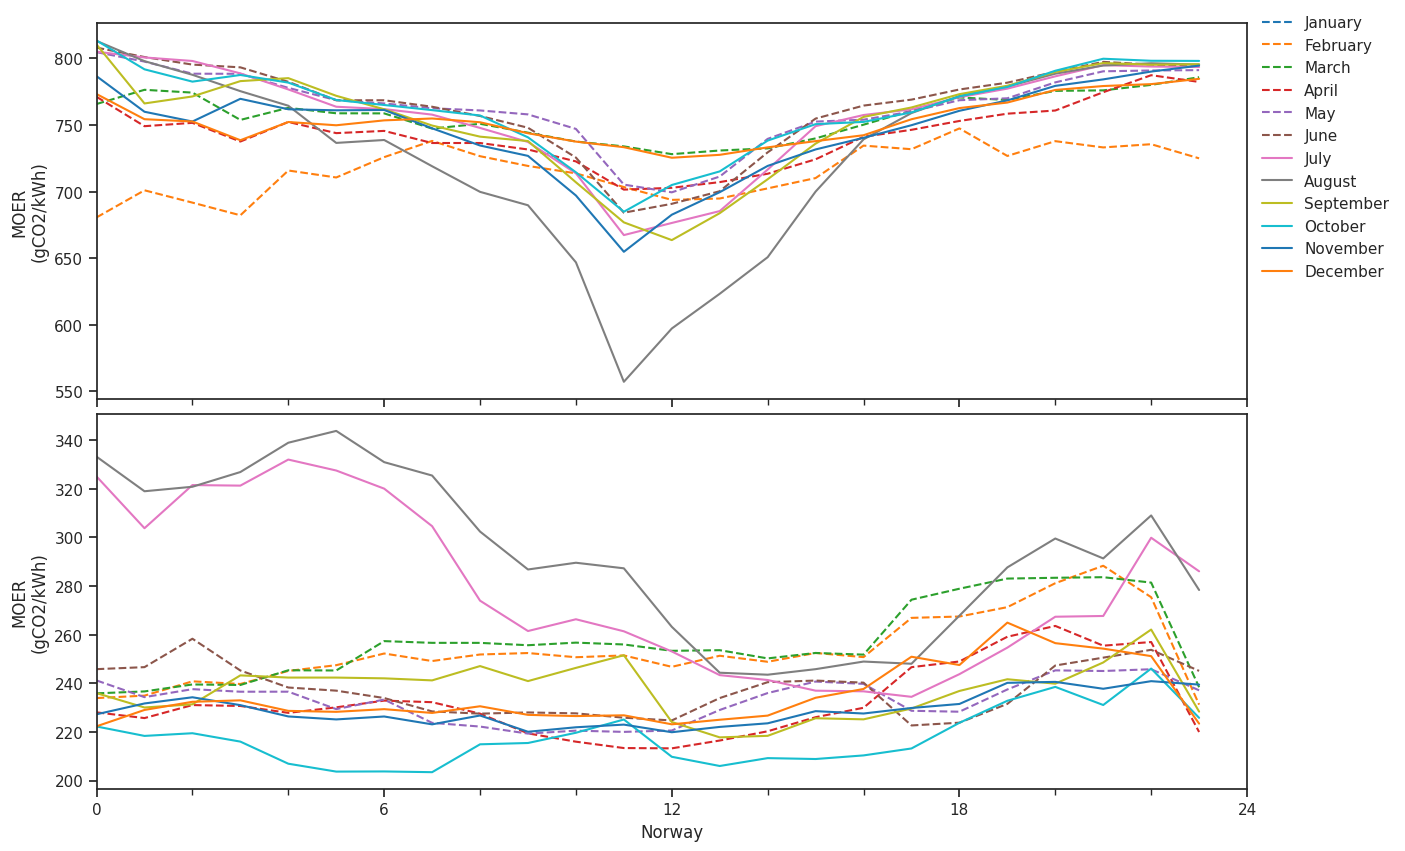

In [ ]:
sns.set_theme(style='ticks')

f, axs = plt.subplots(ncols=1, nrows=2, sharey=False, sharex=True, figsize=(12,8))
f.tight_layout(pad=0)

palette = sns.color_palette("tab10", 12)

for ax, s, country in zip(axs, [moer_de, moer_no], ["Germany", "Norway"]):
    x = pd.DataFrame(s)
    x.index = pd.DatetimeIndex(x.index)

    for month, color, linestyle in zip(range(12), palette, ["--"]*6 + ["-"]*6):
        xm = x[x.index.month == month]
        xm = xm.groupby(xm.index.hour * 60 + xm.index.minute).mean(numeric_only=True)
        ax.plot(xm.index, xm['moer'], color=color, linestyle=linestyle, label=month)

    ax.set(xlabel=country)
    ax.set_xlim(0, 1440)
    ticks = range(0, 24*60+1, 60*6)
    minior_ticks = range(0, 24*60+1, 60*2)
    ax.set_xticks(ticks)
    ax.set_xticks(minior_ticks, minor=True)
    ax.set_xticklabels([f"{int(tick/60)}" for tick in ticks])

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], loc='upper right', bbox_to_anchor=(1.12, 1.02), frameon=False)

axs[0].set(ylabel='MOER\n(gCO2/kWh)')
axs[1].set(ylabel='MOER\n(gCO2/kWh)')

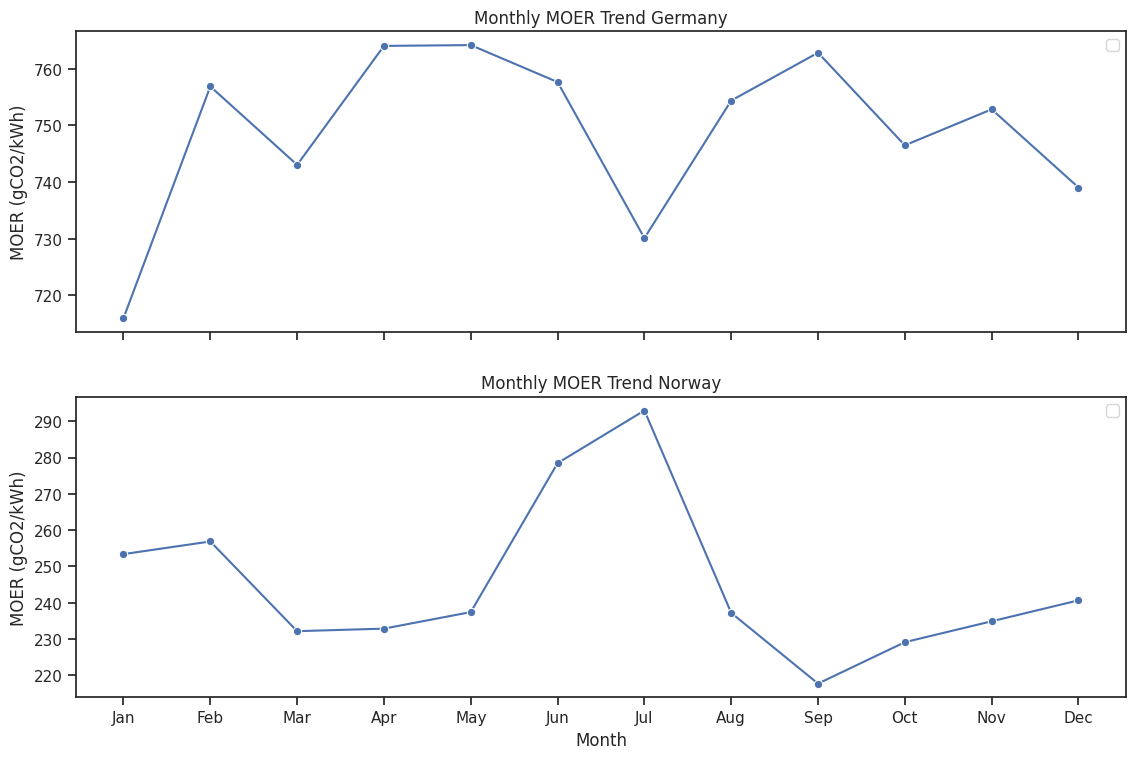

In [ ]:
sns.set_theme(style='ticks')

f, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12, 8))
f.tight_layout(pad=3)
palette = sns.color_palette("tab10", 12)

for ax, df, country in zip(axs, [moer_de, moer_no], ["Germany", "Norway"]):
    df['date'] = pd.to_datetime(df.index)
    df['month'] = df['date'].dt.month

    monthly_trend = df.groupby('month')['moer'].mean().reset_index()

    sns.lineplot(data=monthly_trend, x='month', y='moer', ax=ax, marker='o')

    ax.set_title(f'Monthly MOER Trend {country}')
    ax.set_xlabel('Month')
    ax.set_ylabel('MOER (gCO2/kWh)')
    ax.legend()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axs[1].set_xticks(range(1, 13))
axs[1].set_xticklabels(months)

plt.show()

Energy sources

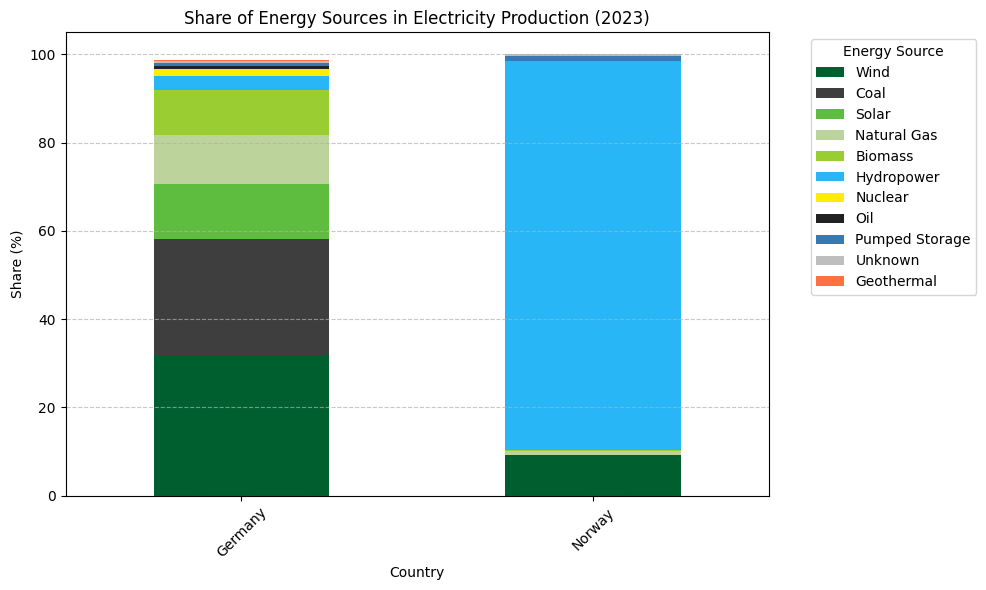

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame from the provided data
data = {
    'Energy Source': ['Wind', 'Coal', 'Solar', 'Natural Gas', 'Biomass', 'Hydropower', 'Nuclear', 'Oil', 'Pumped Storage', 'Unknown', 'Geothermal'],
    'Germany': [31.88, 26.28, 12.45, 11.2, 10.07, 3.23, 1.52, 0.67, 0.66, 0.62, 0.04],
    'Norway': [9.12, 0, 0, 0.96, 0.18, 88.31, 0, 0, 1.15, 0.28, 0]
}

df = pd.DataFrame(data)

# Define greenness colors based on the type of energy source
greenness_colors = {
    'Wind': '#005f2f', # Dark Green
    'Coal': '#3e3e3e', # Brown
    'Solar': '#5ebd3e', # Bright Green
    'Natural Gas': '#bcd39c', # Lighter Green
    'Biomass': '#9acd32', # Medium Green
    'Hydropower': '#29b6f6', # Light Blue
    'Nuclear': '#ffed00', # Yellow
    'Oil': '#222222', # Dark Gray
    'Pumped Storage': '#357ab2', # Blue
    'Unknown': '#bebebe', # Light Gray
    'Geothermal': '#ff7043' # Orange
}

# Assign colors to each energy source
df_colors = [greenness_colors[source] for source in df['Energy Source']]

# Reverse DataFrame for plotting
df_plot = df.set_index('Energy Source').T

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df_plot.plot(kind='bar', stacked=True, color=df_colors, ax=ax)

# Customizing the plot
ax.set_title('Share of Energy Sources in Electricity Production (2023)')
ax.set_xlabel('Country')
ax.set_ylabel('Share (%)')
ax.legend(title='Energy Source', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
# Show the plot
plt.tight_layout()
plt.show()

Weather

In [ ]:
weather_time_moer

country           ghi  precipitation  temperature  \
date                                                                    
2021-01-01 00:00:00      NO  0.000000e+00   4.596687e-05     -4.46052   
2021-01-01 01:00:00      NO  0.000000e+00   4.844980e-05     -4.58634   
2021-01-01 02:00:00      NO  0.000000e+00   4.715853e-05     -4.63306   
2021-01-01 03:00:00      NO  0.000000e+00   4.323623e-05     -4.69846   
2021-01-01 04:00:00      NO  0.000000e+00   4.257162e-05     -4.78565   
...                     ...           ...            ...          ...   
2024-02-29 21:00:00      DE -6.467518e-14   2.435606e-06      4.82380   
2024-02-29 22:00:00      NO -6.467518e-14   1.927261e-04      1.80856   
2024-02-29 22:00:00      DE -6.467518e-14   1.030581e-06      4.28008   
2024-02-29 23:00:00      DE -6.467518e-14   5.369242e-07      3.91686   
2024-02-29 23:00:00      NO -6.467518e-14   1.943275e-04      1.84417   

                     wind_speed  hour_of_day  day_of_week  day_of_year  \
date                                                                     
2021-01-01 00:00:00    3.224764            0            4            1   
2021-01-01 01:00:00    3.212784            1            4            1   
2021-01-01 02:00:00    3.245318            2            4            1   
2021-01-01 03:00:00    3.278241            3            4            1   
2021-01-01 04:00:00    3.293060            4            4            1   
...                         ...          ...          ...          ...   
2024-02-29 21:00:00    6.209530           21            3           60   
2024-02-29 22:00:00    7.141570           22            3           60   
2024-02-29 22:00:00    5.666669           22            3           60   
2024-02-29 23:00:00    5.609017           23            3           60   
2024-02-29 23:00:00    7.296884           23            3           60   

                     is_holiday_or_weekend  season        moer  \
date                                                             
2021-01-01 00:00:00                      1       3  203.133617   
2021-01-01 01:00:00                      1       3  222.963148   
2021-01-01 02:00:00                      1       3  226.198771   
2021-01-01 03:00:00                      1       3  225.673360   
2021-01-01 04:00:00                      1       3  211.577988   
...                                    ...     ...         ...   
2024-02-29 21:00:00                      0       3  793.305948   
2024-02-29 22:00:00                      0       3  256.014885   
2024-02-29 22:00:00                      0       3  797.868328   
2024-02-29 23:00:00                      0       3  790.845212   
2024-02-29 23:00:00                      0       3  251.841838   

                                   date  
date                                     
2021-01-01 00:00:00 2021-01-01 00:00:00  
2021-01-01 01:00:00 2021-01-01 01:00:00  
2021-01-01 02:00:00 2021-01-01 02:00:00  
2021-01-01 03:00:00 2021-01-01 03:00:00  
2021-01-01 04:00:00 2021-01-01 04:00:00  
...                                 ...  
2024-02-29 21:00:00 2024-02-29 21:00:00  
2024-02-29 22:00:00 2024-02-29 22:00:00  
2024-02-29 22:00:00 2024-02-29 22:00:00  
2024-02-29 23:00:00 2024-02-29 23:00:00  
2024-02-29 23:00:00 2024-02-29 23:00:00  

[40128 rows x 12 columns]

<ipython-input-57-082f27dbd075>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_averages = weather_time_moer.groupby(['country', 'month']).mean().reset_index()


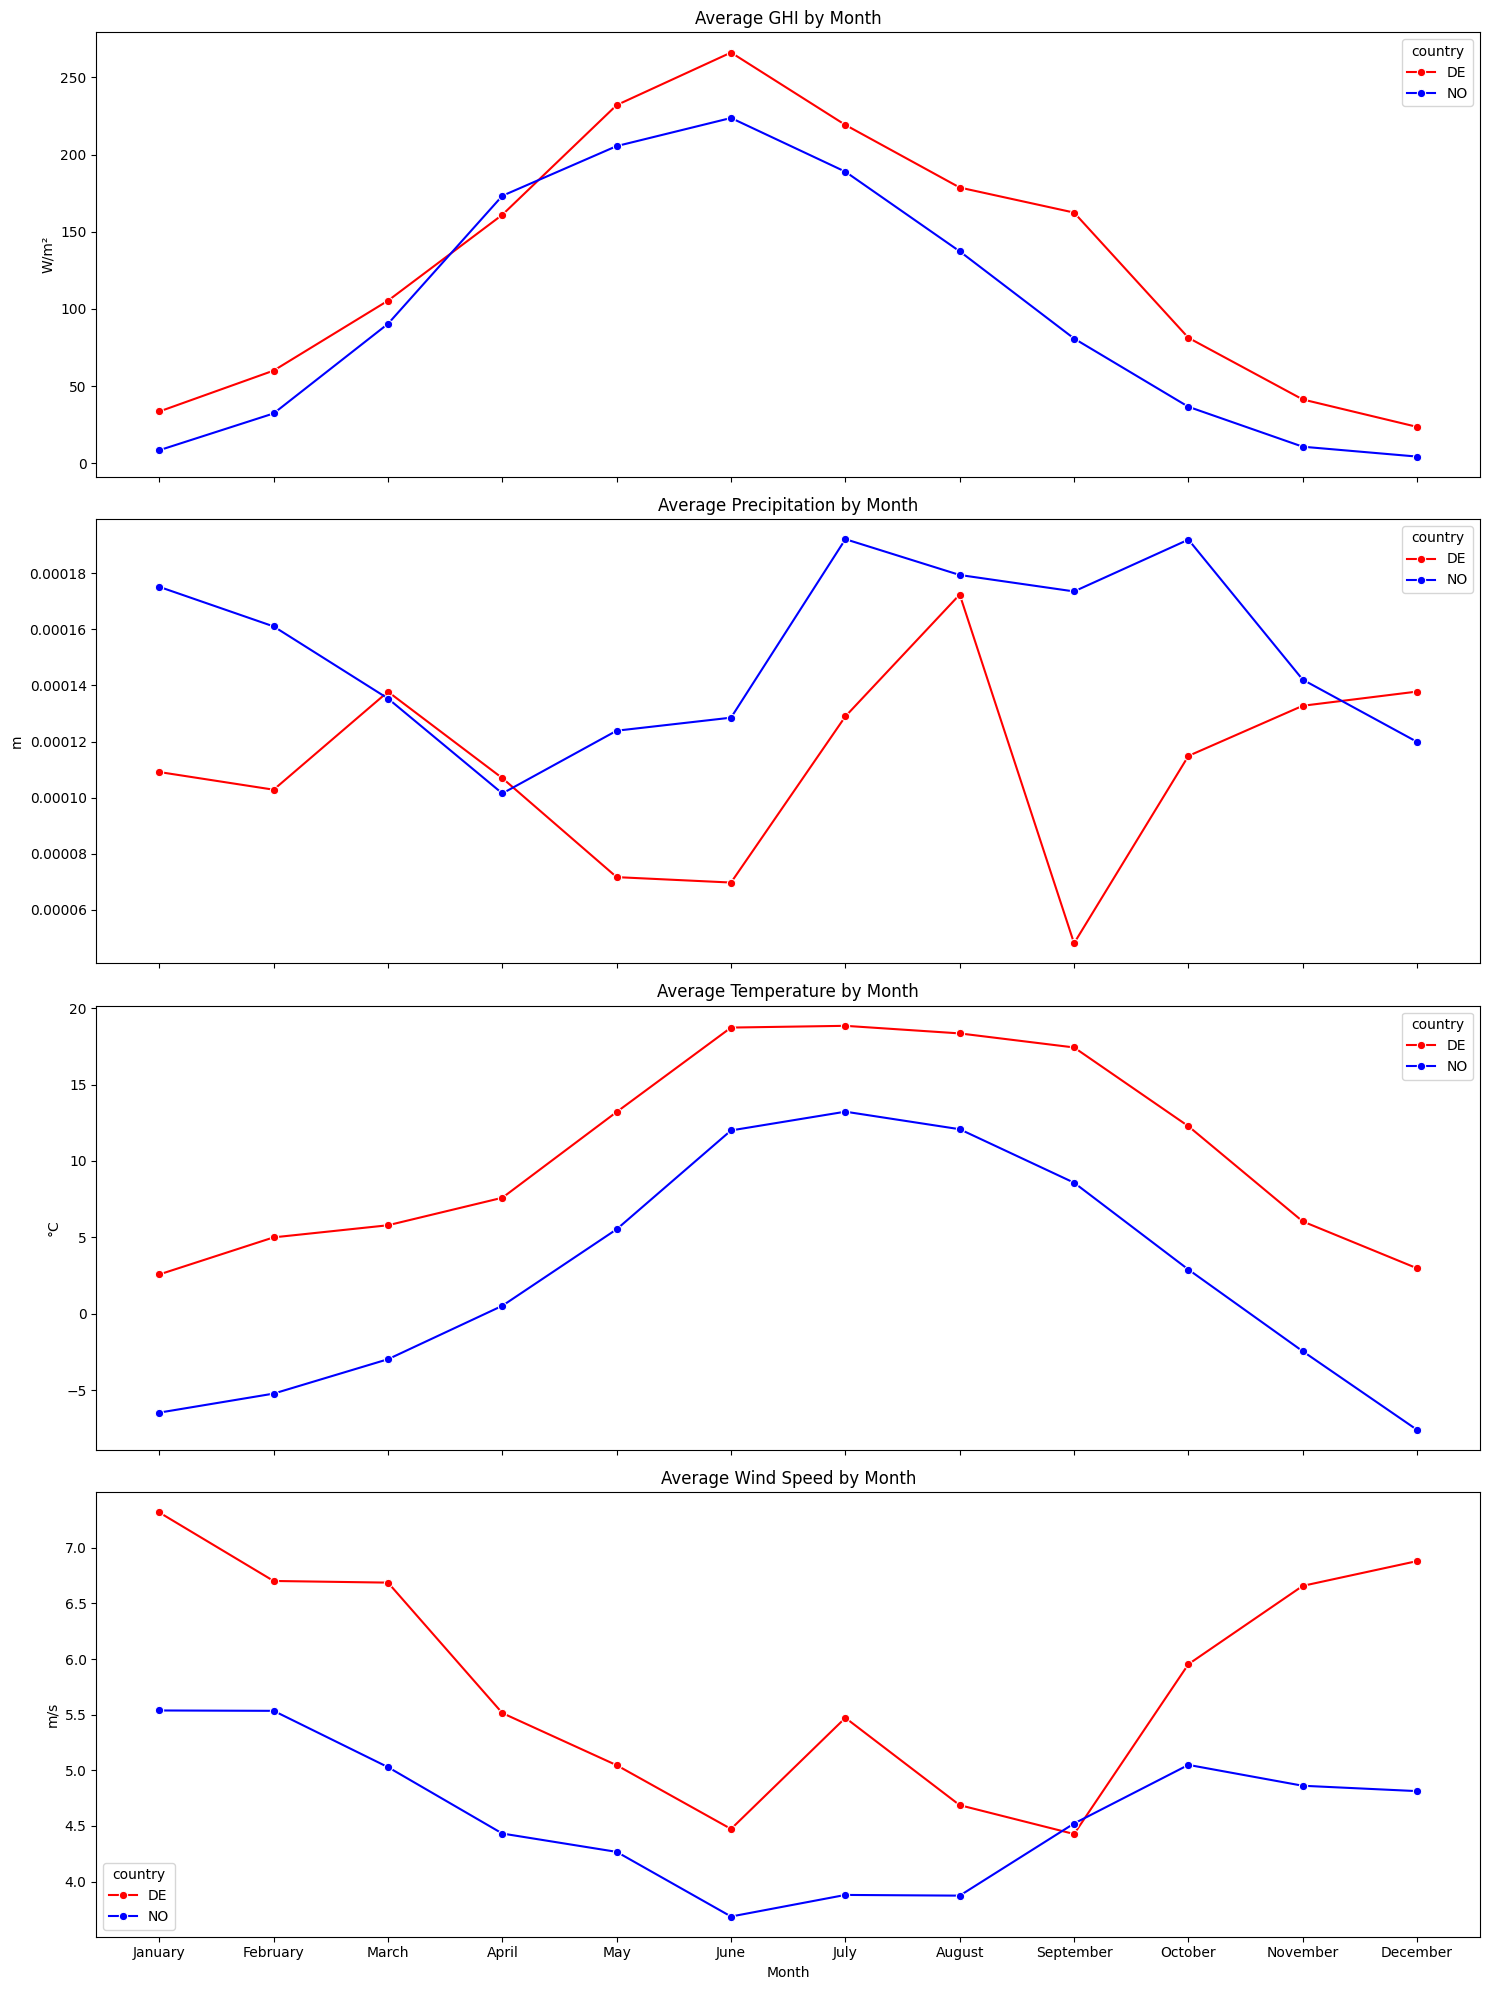

In [ ]:
weather_time_moer['date'] = pd.to_datetime(weather_time_moer.index)
weather_time_moer['month'] = weather_time_moer['date'].dt.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
weather_time_moer['month'] = pd.Categorical(weather_time_moer['month'], categories=month_order, ordered=True)

country_palette = {'NO': 'blue', 'DE': 'red'}
plot_titles = {
    'ghi': 'GHI',
    'precipitation': 'Precipitation',
    'temperature': 'Temperature',
    'wind_speed': 'Wind Speed'
}
units = {
    'ghi': 'W/m²',
    'wind_speed': 'm/s',
    'temperature': '°C',
    'precipitation': 'm'
}

monthly_averages = weather_time_moer.groupby(['country', 'month']).mean().reset_index()
fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

for i, variable in enumerate(plot_titles.keys()):
    sns.lineplot(data=monthly_averages, x='month', y=variable, hue='country', ax=axes[i], marker='o', palette=country_palette)
    axes[i].set_title(f'Average {plot_titles[variable]} by Month')
    axes[i].set_ylabel(f'{units[variable]}')

axes[-1].set_xlabel('Month')
plt.tight_layout()
plt.show()

<ipython-input-61-bedc60401b91>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_averages = weather_time_moer.groupby(['country', 'month']).mean().reset_index()


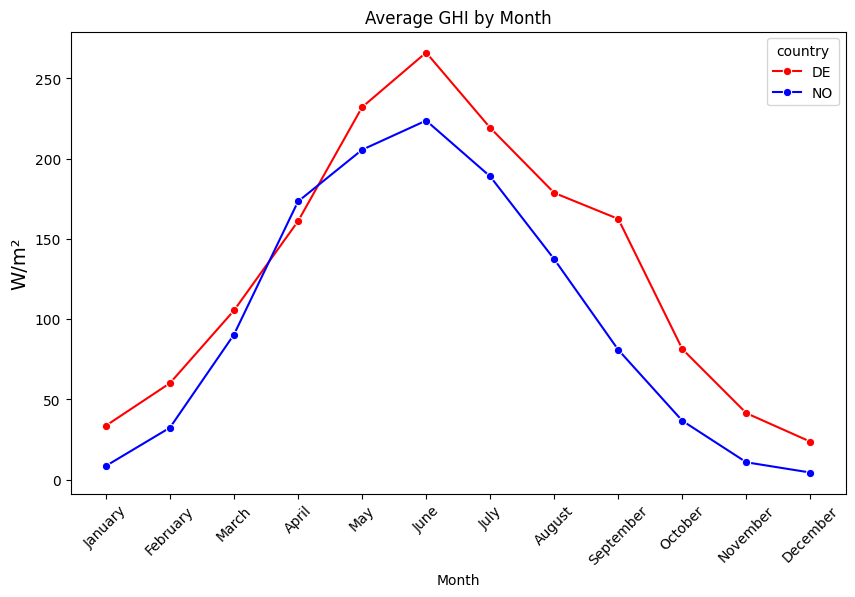

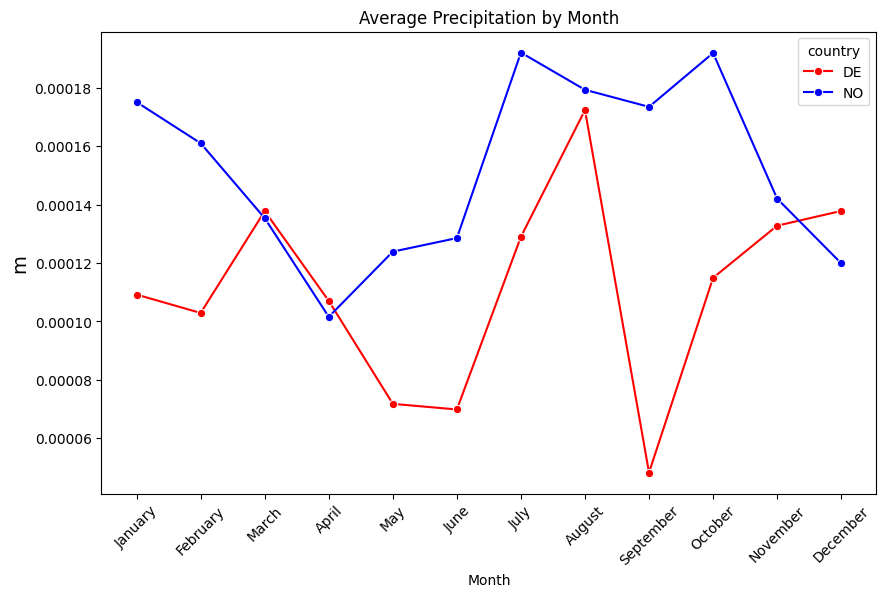

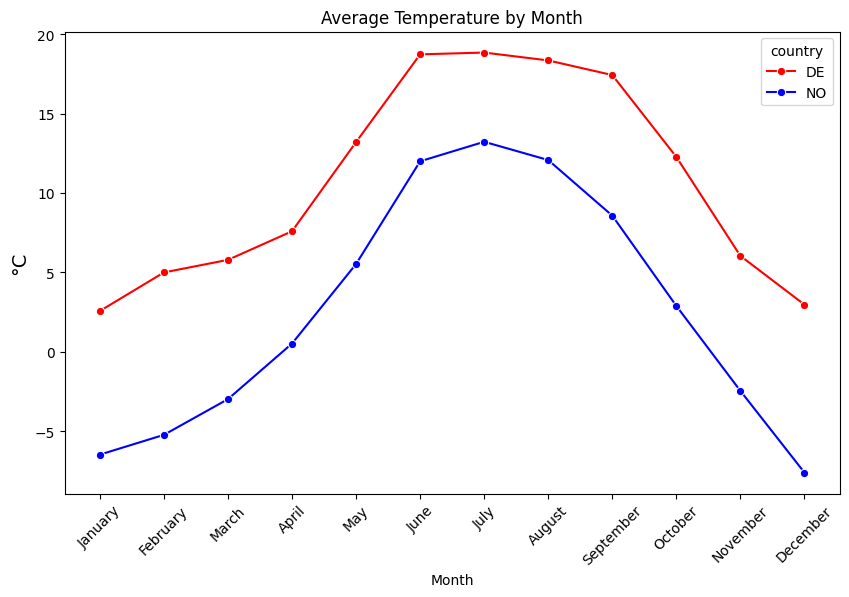

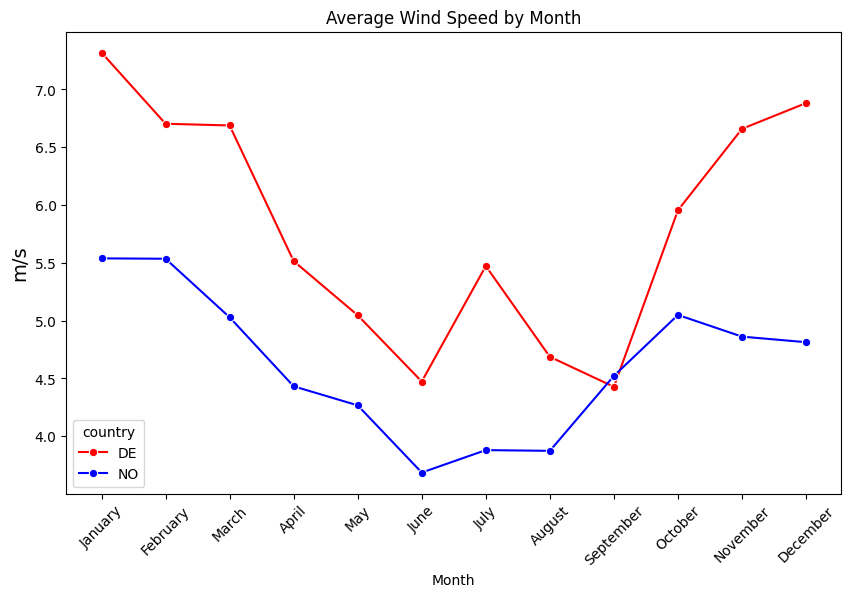

In [ ]:
weather_time_moer['date'] = pd.to_datetime(weather_time_moer.index)
weather_time_moer['month'] = weather_time_moer['date'].dt.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
weather_time_moer['month'] = pd.Categorical(weather_time_moer['month'], categories=month_order, ordered=True)
monthly_averages = weather_time_moer.groupby(['country', 'month']).mean().reset_index()

country_palette = {'NO': 'blue', 'DE': 'red'}
plot_titles = {
    'ghi': 'GHI',
    'precipitation': 'Precipitation',
    'temperature': 'Temperature',
    'wind_speed': 'Wind Speed'
}
units = {
    'ghi': 'W/m²',
    'precipitation': 'm',
    'temperature': '°C',
    'wind_speed': 'm/s'
}

for variable in plot_titles.keys():
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=monthly_averages, x='month', y=variable, hue='country', marker='o', palette=country_palette)
    plt.title(f'Average {plot_titles[variable]} by Month')
    plt.ylabel(units[variable], fontsize=14)
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.show()

**Calculate CI for TFT training**

*TFT Training took 72 hours and was done in January 2024*

Calculation based on:
*   72 lowest moer values in January 2024
*   72 highest moer values in January 2024
*   Intel Xenon CPU
*   Tesla T4 GPU
*   PUE






In [23]:
moer_de_jan24 = moer_de.loc['2024-01-01':'2024-02-01']
lowest_72_moer = moer_de_jan24.sort_values(by='moer').head(72)
highest_72_moer = moer_de_jan24.sort_values(by='moer').tail(72)
lowest_72_moer

moer
date                           
2024-01-03 02:00:00  270.813324
2024-01-03 01:00:00  275.757476
2024-01-24 02:00:00  343.240626
2024-01-24 01:00:00  402.279405
2024-01-03 03:00:00  415.244576
...                         ...
2024-01-11 12:00:00  751.976157
2024-01-13 11:00:00  752.044196
2024-01-05 11:00:00  752.104675
2024-01-14 12:00:00  752.116015
2024-01-27 13:00:00  752.123575

[72 rows x 1 columns]

In [26]:
cpu_utilization = 0.47
gpu_power_average = 56.23 # W
cpu_tdp = 95 # W
pue = 1.1

power_consumption_per_h_kWh = (
    ((1 * cpu_tdp * cpu_utilization) + gpu_power_average) * pue
) / 1000

print(f"Estimated Power Consumption per h: {power_consumption_per_h_kWh} kWh")

Estimated Power Consumption per h: 0.110968 kWh


In [27]:
carbon_intensity_lowest = sum(power_consumption_per_h_kWh * lowest_72_moer['moer'])
carbon_intensity_highest = sum(power_consumption_per_h_kWh * highest_72_moer['moer'])

print(f"CI 72 lowest MOER Jan'24: {round(carbon_intensity_lowest / 1000, 2)} kg CO2eq")
print(f"CI 72 lowest MOER Jan'24: {round(carbon_intensity_highest / 1000, 2)} kg CO2eq")

CI 72 lowest MOER Jan'24: 5.6 kg CO2eq
CI 72 lowest MOER Jan'24: 6.44 kg CO2eq


## **Compare MOER and price**

In [ ]:
wholesale_price = pd.read_csv(base_path + 'SMARD/Gro_handelspreise_202210010000_202312312359_Stunde.csv', sep=';')
wholesale_price

Datum Anfang   Ende  \
0      01.10.2022  00:00  01:00   
1      01.10.2022  01:00  02:00   
2      01.10.2022  02:00  03:00   
3      01.10.2022  03:00  04:00   
4      01.10.2022  04:00  05:00   
...           ...    ...    ...   
10964  31.12.2023  19:00  20:00   
10965  31.12.2023  20:00  21:00   
10966  31.12.2023  21:00  22:00   
10967  31.12.2023  22:00  23:00   
10968  31.12.2023  23:00  00:00   

      Deutschland/Luxemburg [€/MWh] Originalauflösungen  \
0                                                 64,41   
1                                                 63,59   
2                                                    50   
3                                                 21,48   
4                                                 16,91   
...                                                 ...   
10964                                                 9   
10965                                              7,95   
10966                                                 6   
10967                                             10,68   
10968                                              2,44   

      ∅ Anrainer DE/LU [€/MWh] Originalauflösungen  \
0                                           125,44   
1                                            99,98   
2                                            92,12   
3                                            73,36   
4                                            66,83   
...                                            ...   
10964                                         33,2   
10965                                         29,6   
10966                                        22,61   
10967                                         24,2   
10968                                        19,26   

      Belgien [€/MWh] Originalauflösungen  \
0                                    96,7   
1                                   63,59   
2                                      50   
3                                   21,48   
4                                   16,91   
...                                   ...   
10964                               20,26   
10965                               19,65   
10966                                   9   
10967                               10,68   
10968                                3,17   

      Dänemark 1 [€/MWh] Originalauflösungen  \
0                                      64,41   
1                                      63,59   
2                                         50   
3                                      21,48   
4                                      16,91   
...                                      ...   
10964                                  39,64   
10965                                  34,89   
10966                                   29,6   
10967                                  28,67   
10968                                  26,87   

      Dänemark 2 [€/MWh] Originalauflösungen  \
0                                      64,41   
1                                      63,59   
2                                         50   
3                                      21,48   
4                                      16,91   
...                                      ...   
10964                                  39,64   
10965                                  34,89   
10966                                   29,6   
10967                                  28,67   
10968                                  26,87   

      Frankreich [€/MWh] Originalauflösungen  \
0                                        167   
1                                      103,8   
2                                      90,56   
3                                      77,64   
4                                      50,25   
...                                      ...   
10964                                  17,75   
10965                                  16,43   
10966                                   8,16   
10967                                  10,68   
10968     

In [ ]:
wholesale_price_de = wholesale_price[['Datum', 'Anfang', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']]
wholesale_price_de['date'] = pd.to_datetime(wholesale_price_de['Datum'] + " " + wholesale_price_de['Anfang'], dayfirst=True)
wholesale_price_de.rename(columns={'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'wholesale price DE/LU in €/MWh'}, inplace=True)

if wholesale_price_de['date'].duplicated().any():
    wholesale_price_de = wholesale_price_de.drop_duplicates(subset=['date'])

wholesale_price_de.set_index('date', inplace=True)

wholesale_price_de['wholesale price DE/LU in €/MWh'] = wholesale_price_de['wholesale price DE/LU in €/MWh'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
wholesale_price_de['wholesale price DE/LU in €/MWh'] = wholesale_price_de['wholesale price DE/LU in €/MWh'].astype(float)
wholesale_price_de

<ipython-input-7-5e4abc5968f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wholesale_price_de['date'] = pd.to_datetime(wholesale_price_de['Datum'] + " " + wholesale_price_de['Anfang'], dayfirst=True)
<ipython-input-7-5e4abc5968f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wholesale_price_de.rename(columns={'Deutschland/Luxemburg [€/MWh] Originalauflösungen': 'wholesale price DE/LU in €/MWh'}, inplace=True)


Datum Anfang  wholesale price DE/LU in €/MWh
date                                                                  
2022-10-01 00:00:00  01.10.2022  00:00                           64.41
2022-10-01 01:00:00  01.10.2022  01:00                           63.59
2022-10-01 02:00:00  01.10.2022  02:00                           50.00
2022-10-01 03:00:00  01.10.2022  03:00                           21.48
2022-10-01 04:00:00  01.10.2022  04:00                           16.91
...                         ...    ...                             ...
2023-12-31 19:00:00  31.12.2023  19:00                            9.00
2023-12-31 20:00:00  31.12.2023  20:00                            7.95
2023-12-31 21:00:00  31.12.2023  21:00                            6.00
2023-12-31 22:00:00  31.12.2023  22:00                           10.68
2023-12-31 23:00:00  31.12.2023  23:00                            2.44

[10967 rows x 3 columns]

In [ ]:
df_combined = pd.concat([wholesale_price_de['wholesale price DE/LU in €/MWh'], moer_de['moer']], axis=1)
df_combined
moer_de['price'] = wholesale_price_de['wholesale price DE/LU in €/MWh']
moer_de

moer  price
date                                  
2022-10-01 00:00:00  785.209331  64.41
2022-10-01 01:00:00  752.652765  63.59
2022-10-01 02:00:00  789.344578  50.00
2022-10-01 03:00:00  786.490729  21.48
2022-10-01 04:00:00  786.589007  16.91
...                         ...    ...
2024-02-29 19:00:00  779.622590    NaN
2024-02-29 20:00:00  786.211014    NaN
2024-02-29 21:00:00  793.305948    NaN
2024-02-29 22:00:00  797.868328    NaN
2024-02-29 23:00:00  790.845212    NaN

[12408 rows x 2 columns]

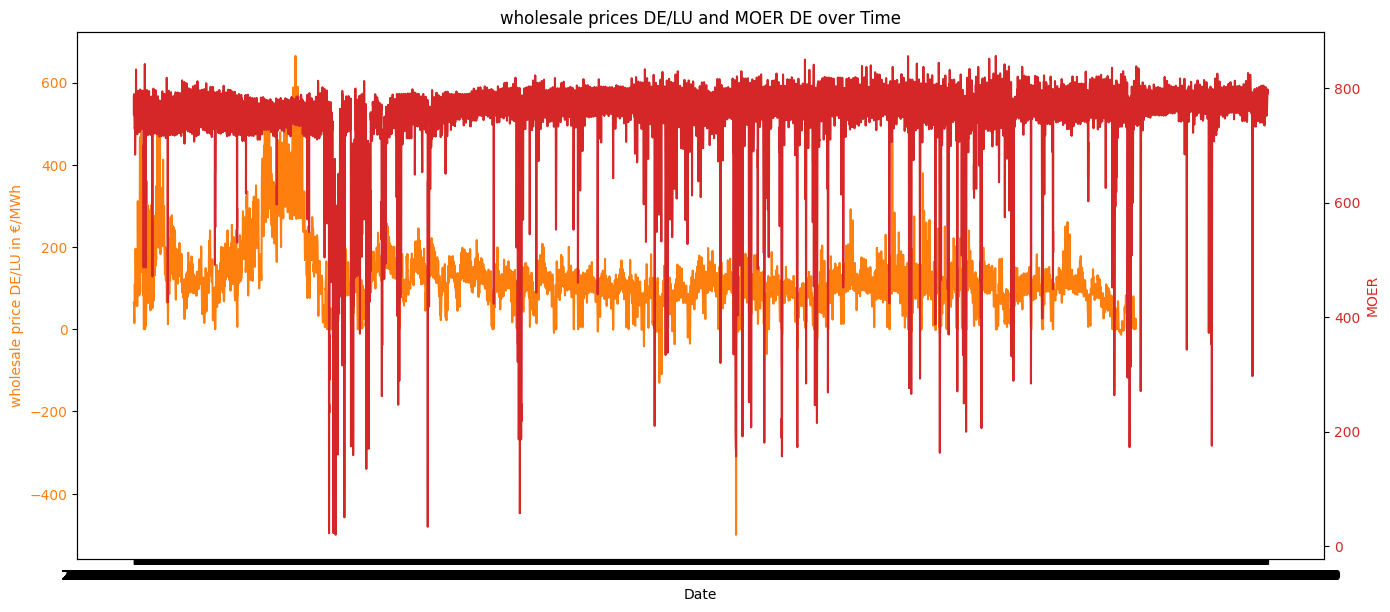

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('wholesale price DE/LU in €/MWh', color=color)
ax1.plot(moer_de.index, moer_de['price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MOER', color=color)
ax2.plot(moer_de.index, moer_de['moer'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('wholesale prices DE/LU and MOER DE over Time')
plt.show()

In [ ]:
df_combined = pd.concat([wholesale_price_de['wholesale price DE/LU in €/MWh'], moer_de_filtered['moer']], axis=1)
df_combined
moer_de_filtered['price'] = wholesale_price_de['wholesale price DE/LU in €/MWh']
moer_de_filtered.to_csv(base_path + 'moer_de_filterd_wholesale_price.csv', index='date')
moer_de_filtered

moer  price
date                                  
2022-10-01 00:00:00  785.209331  64.41
2022-10-01 01:00:00  752.652765  63.59
2022-10-01 02:00:00  789.344578  50.00
2022-10-01 03:00:00  786.490729  21.48
2022-10-01 04:00:00  786.589007  16.91
...                         ...    ...
2024-02-29 19:00:00  779.622590    NaN
2024-02-29 20:00:00  786.211014    NaN
2024-02-29 21:00:00  793.305948    NaN
2024-02-29 22:00:00  797.868328    NaN
2024-02-29 23:00:00  790.845212    NaN

[11526 rows x 2 columns]

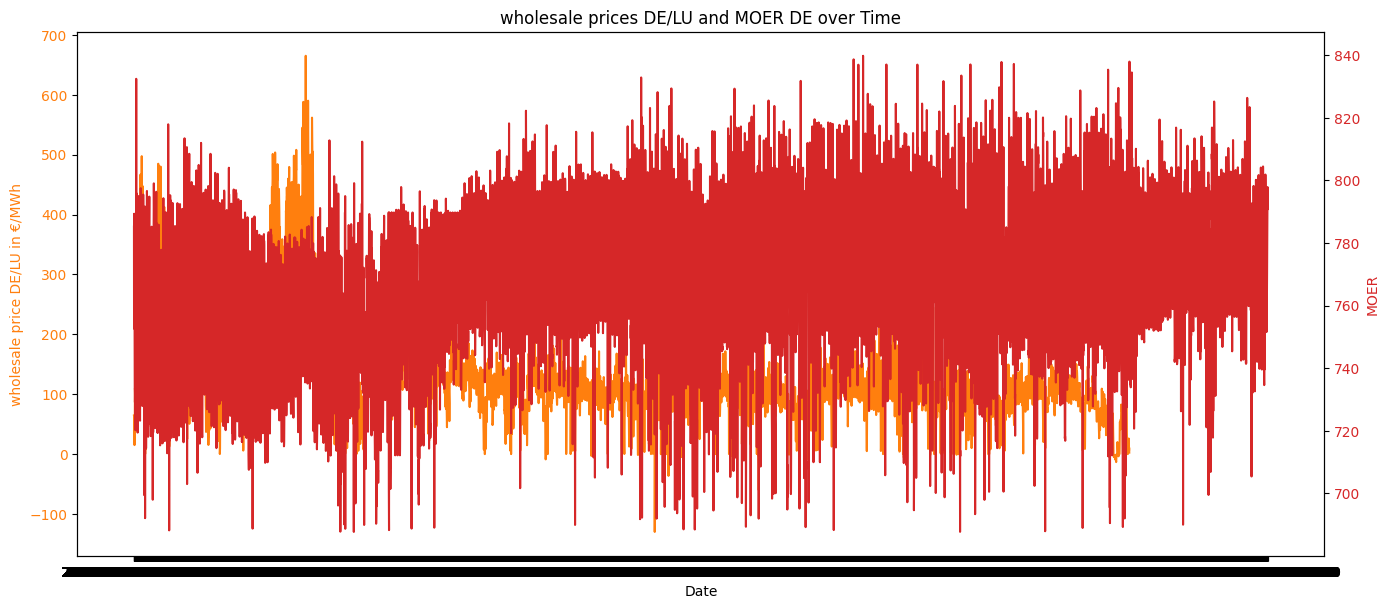

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:orange'
ax1.set_xlabel('Date')
ax1.set_ylabel('wholesale price DE/LU in €/MWh', color=color)
ax1.plot(moer_de_filtered.index, moer_de_filtered['price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MOER', color=color)
ax2.plot(moer_de_filtered.index, moer_de_filtered['moer'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('wholesale prices DE/LU and MOER DE over Time')
plt.tight_layout()
plt.show()

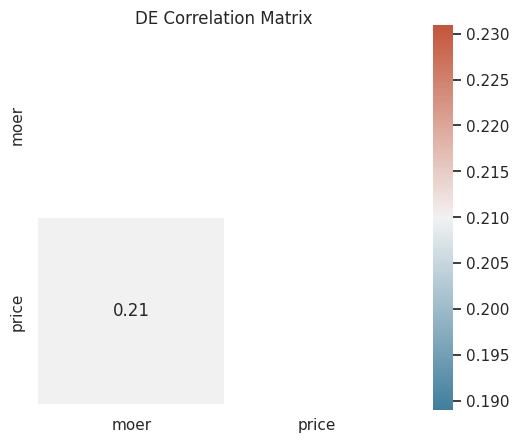

In [ ]:
de_moer_price_corr = moer_de.select_dtypes(include=[np.number]).corr()

sns.set_theme(style="white")
mask = np.triu(np.ones_like(de_moer_price_corr, dtype=bool))

plt.figure(figsize=(6, 5))
sns.heatmap(de_moer_price_corr, mask=mask, annot=True, fmt=".2f",
            cmap=sns.diverging_palette(230, 20, as_cmap=True), square=True)
plt.title('DE Correlation Matrix')
plt.show()

## **Analyze filtered data**

In [ ]:
weather_time_moer_filtered = pd.read_csv(base_path + weather_time_moer_filtered_file_name, index_col='date')
moer_de_filtered = weather_time_moer_filtered[weather_time_moer_filtered['country'] == "DE"][['moer']]
moer_no_filtered = weather_time_moer_filtered[weather_time_moer_filtered['country'] == "NO"][['moer']]

Distribution

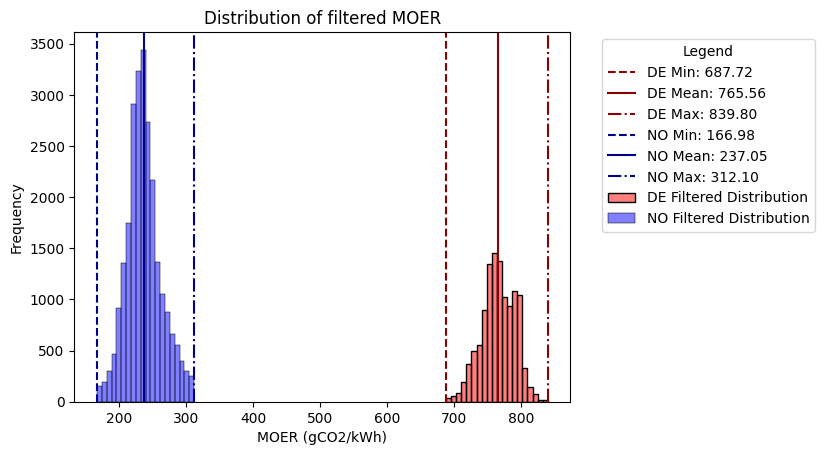

In [ ]:
sns.histplot(data=moer_de_filtered, x='moer', bins=20, color='red', alpha=0.5, label='DE Filtered Distribution')
sns.histplot(data=moer_no_filtered, x='moer', bins=20, color='blue', alpha=0.5, label='NO Filtered Distribution')

min_de_filtered, max_de_filtered, mean_de_filtered = moer_de_filtered['moer'].min(), moer_de_filtered['moer'].max(), moer_de_filtered['moer'].mean()
min_no_filtered, max_no_filtered, mean_no_filtered = moer_no_filtered['moer'].min(), moer_no_filtered['moer'].max(), moer_no_filtered['moer'].mean()

plt.axvline(min_de_filtered, color='darkred', linestyle='--', label=f'DE Min: {min_de_filtered:.2f}')
plt.axvline(mean_de_filtered, color='darkred', linestyle='-', label=f'DE Mean: {mean_de_filtered:.2f}')
plt.axvline(max_de_filtered, color='darkred', linestyle='-.', label=f'DE Max: {max_de_filtered:.2f}')

plt.axvline(min_no_filtered, color='darkblue', linestyle='--', label=f'NO Min: {min_no_filtered:.2f}')
plt.axvline(mean_no_filtered, color='darkblue', linestyle='-', label=f'NO Mean: {mean_no_filtered:.2f}')
plt.axvline(max_no_filtered, color='darkblue', linestyle='-.', label=f'NO Max: {max_no_filtered:.2f}')

plt.title('Distribution of filtered MOER')
plt.xlabel('MOER (gCO2/kWh)')
plt.ylabel('Frequency')

plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.savefig('moer_distribution.png', bbox_inches='tight')
plt.show()

ADF Test

In [ ]:
# H0: data is non stationary
# H1: data is stationary

moer_values_filtered = moer_de_filtered['moer'].values
result = adfuller(moer_values_filtered)

adf_statistic = result[0]
p_value = result[1]
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print('null hypothesis rejected --> data is stationary')
else:
    print('Failed to reject null hypothesis --> data is not stationary')

ADF Statistic: -6.905374903204298
p-value: 1.2511986654486453e-09
null hypothesis rejected --> data is stationary


In [ ]:
# H0: data is non stationary
# H1: data is stationary

moer_values_filtered = moer_no_filtered['moer'].values
result = adfuller(moer_values_filtered)

adf_statistic = result[0]
p_value = result[1]
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print('null hypothesis rejected --> data is stationary')
else:
    print('Failed to reject null hypothesis --> data is not stationary')

ADF Statistic: -5.843767084446921
p-value: 3.724702517362061e-07
null hypothesis rejected --> data is stationary


<Figure size 1400x700 with 0 Axes>

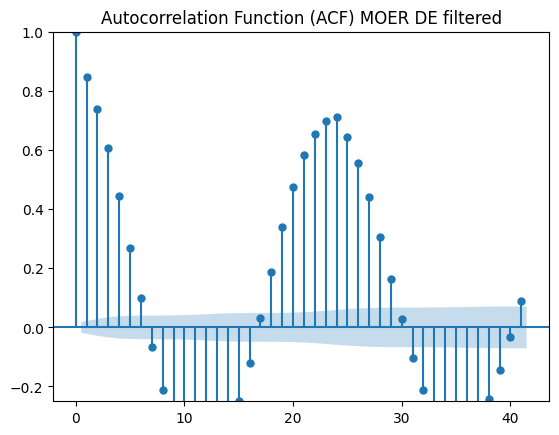

In [ ]:
# ACF DE
plt.figure(figsize=(14, 7))
plot_acf(moer_de_filtered['moer'])
plt.ylim(-0.25,1)
plt.title('Autocorrelation Function (ACF) MOER DE filtered')
plt.show()

<Figure size 1400x700 with 0 Axes>

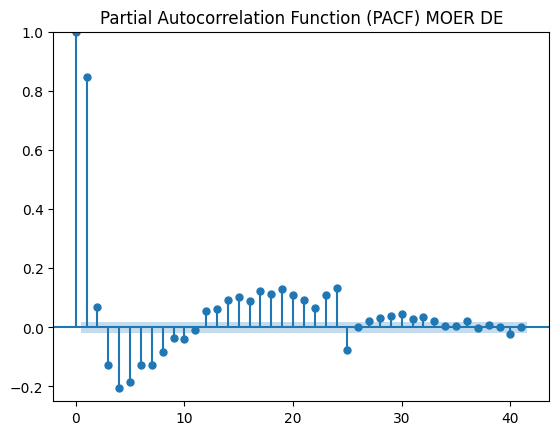

In [ ]:
# PACF DE
plt.figure(figsize=(14, 7))
plot_pacf(moer_de_filtered['moer'])
plt.ylim(-0.25,1)
plt.title('Partial Autocorrelation Function (PACF) MOER DE')
plt.show()

<Figure size 1400x700 with 0 Axes>

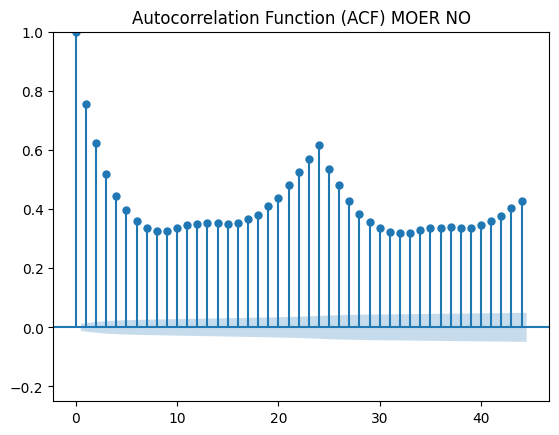

In [ ]:
# ACF NO
plt.figure(figsize=(14, 7))
plot_acf(moer_no_filtered['moer'])
plt.ylim(-0.25,1)
plt.title('Autocorrelation Function (ACF) MOER NO')
plt.show()

<Figure size 1400x700 with 0 Axes>

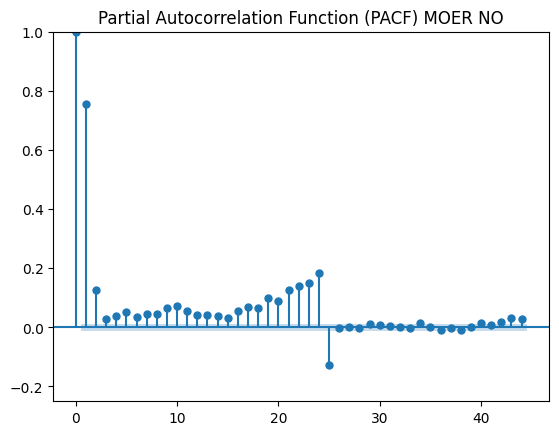

In [ ]:
# PACF NO
plt.figure(figsize=(14, 7))
plot_pacf(moer_no_filtered['moer'])
plt.ylim(-0.25,1)
plt.title('Partial Autocorrelation Function (PACF) MOER NO')
plt.show()